# The notebook that uses `LeakySimulator.py`

### Part I.  General run

Here I test the class and show how to use it. 

### Part II. Find critical parameter ranges

For some parameters, testing a range of values for which critical behaviour could be displayed.

### Part III. Some distributions

### Part IV. STDP

## Dependencies and settings

In [210]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
import random
# other
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import json
import time 
import timeit
import itertools
import numpy as np
from importlib import reload 
from itertools import permutations 
from itertools import combinations 
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")

import LeakySimulator as sim
reload(sim);

# initialise useful functions
U = sim.Usefulfunctions()

# 0 Set parameters

- change parameter values with this function, like: `J_in=-46.` for example.

In [211]:
def set_params(J_ex=6., J_in=-95., C_m=250.0, NE=960, NI=240, stim_end=150.):
    
    sim_params = {

            'N_total':1200,
            'NE': 960, # Default: 4/5 are exci neurons, 1/5 are inh neurons
            'NI': 240,
            'eps':0.1,  # connection probability
            'J_in':-95.0,
            'J_ex':6.0,
            'resolution':0.1,  # temporal resolution of simulation in ms. Kumar2008: 0.1
            'delay':1.5,  # synaptic delay in the network
            'n_threads':8,
            'stim_start':0., # start applying current (dc)
            'stim_end':150., # end applying current (dc)
            'simtime':1000., # simulation time 
            'sub_fr':0.9, # subthreshold current amplitude
            'sup_fr':1.01, # suprathreshold current amplitude
        }

    model_params = {

            'C_m': 250.0,
            'E_L': -70.0,
            'E_ex': 0.0,
            'E_in': -80.0,
            'I_e': 0.0,
            'V_reset': -70.0,
            'V_th': -50.0,
            'g_L': 16.7,
            't_ref': 2.0, # Duration of refractory period
            'tau_syn_ex': 0.326, # Rise time of the excitatory synaptic alpha function
            'tau_syn_in': 0.326,
        }

    # parameters for STDP synapses
    
    syn_params_ex = {

            'model':'stdp_synapse',
            'lambda': 0.01,
            'alpha': 1.0,
            'delay': 1.5,
            'weight': 6.0,
            'Wmax': 100.0   
        }

    syn_params_in = {

            'model':'stdp_synapse',
            'lambda': 0.01,
            'alpha': 1.0,
            'delay': 1.5,
            'weight':-95.0,
            'Wmax':-100.0  
        }
    
    
    sim_params['NE'] = NE
    sim_params['NI'] = NI
    sim_params['J_in'] = J_in
    sim_params['J_ex'] = J_ex
    sim_params['C_m'] = C_m
    
    syn_params_ex['weight'] = J_ex
    syn_params_in['weight'] = J_in
    
    return sim_params, model_params, syn_params_ex, syn_params_in

# 1 Make patterns

- choose a seed
- run the generator

In [151]:
patterns = []
# make permutations for 8 bit pattern
for perm in U.make_permutations():
    patterns.append(perm)

# 2 Initialise and build network

In [139]:
sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=-45.)
# initialise class
LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
# build network
LS.build_network()

# 3 Simulate 

- simulate the network for all the 70 patterns and obtain the data

In [140]:
spikedet_lst = []
multimet_lst = []

spike_times_lst = []
spike_neurons_lst = []
events_lst = []
times_lst = []

for p in patterns:
    
    LS.set_pattern(p)
    
    spikedet, multimet, spike_times, spike_neurons, events, etimes = LS.simulate() 
    spikedet_lst.append(spikedet)
    multimet_lst.append(multimet)
    spike_times_lst.append(spike_times)
    spike_neurons_lst.append(spike_neurons)
    events_lst.append(events)
    times_lst.append(etimes)
    

print('Ran all simulations.')

Ran all simulations.


# 4 Visualise

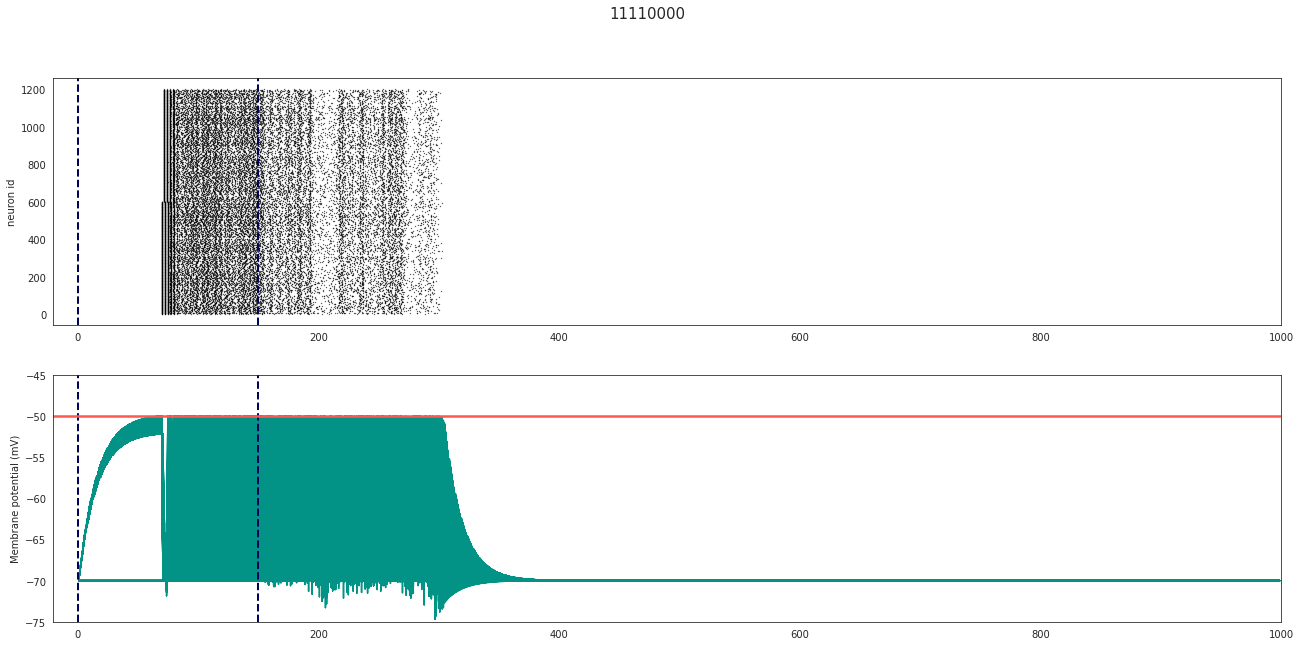

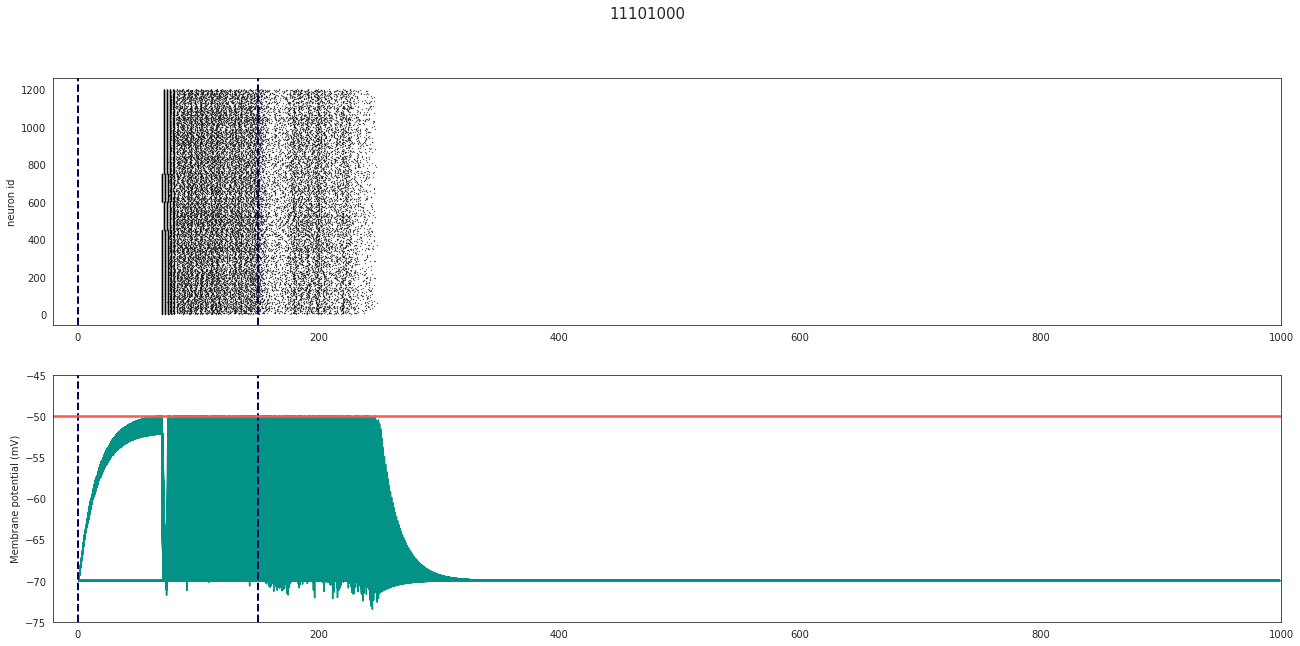

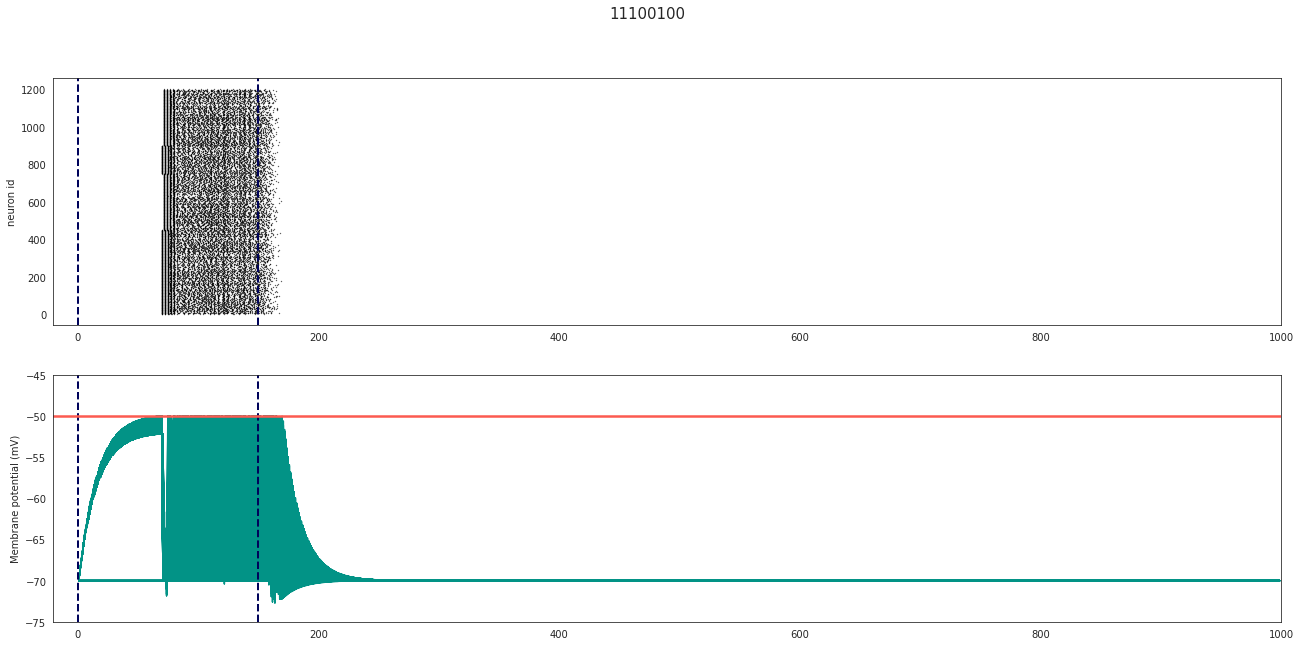

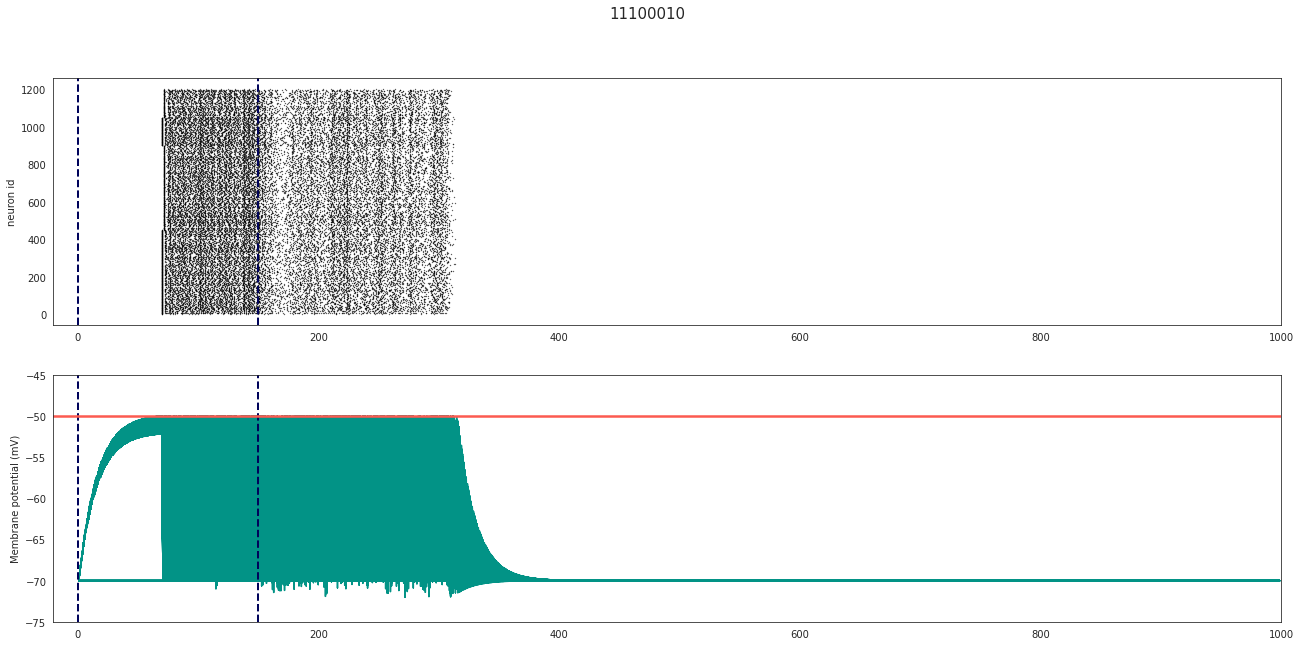

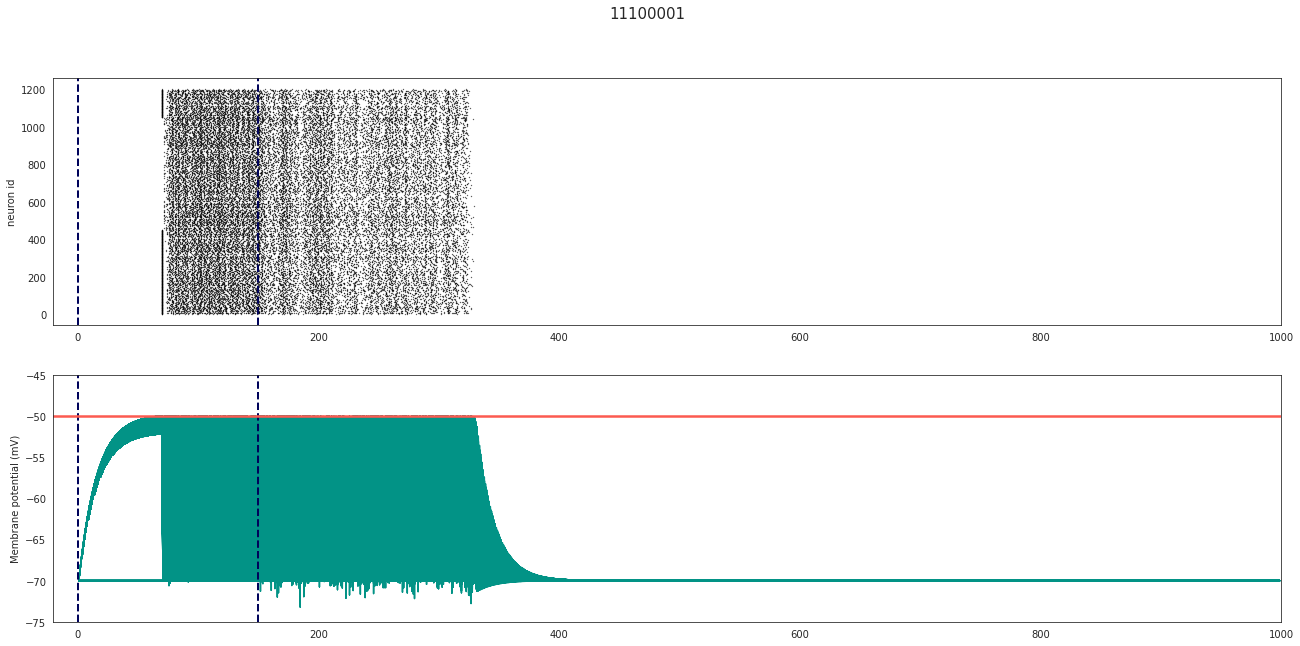

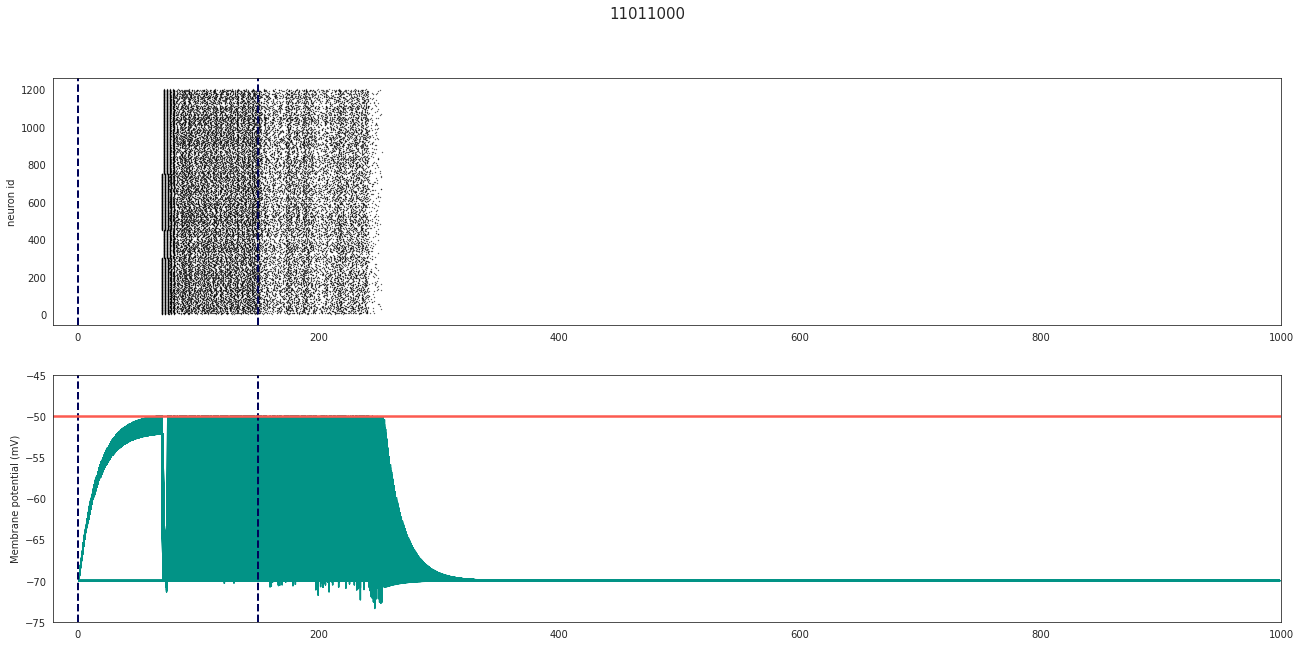

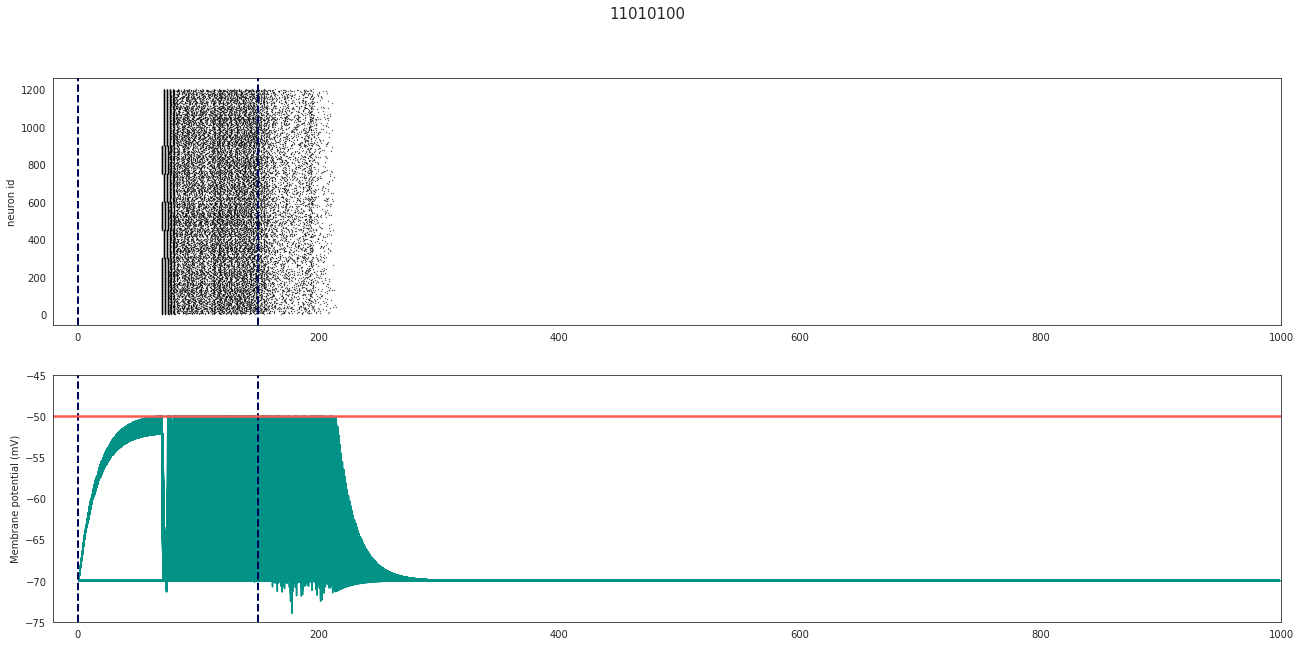

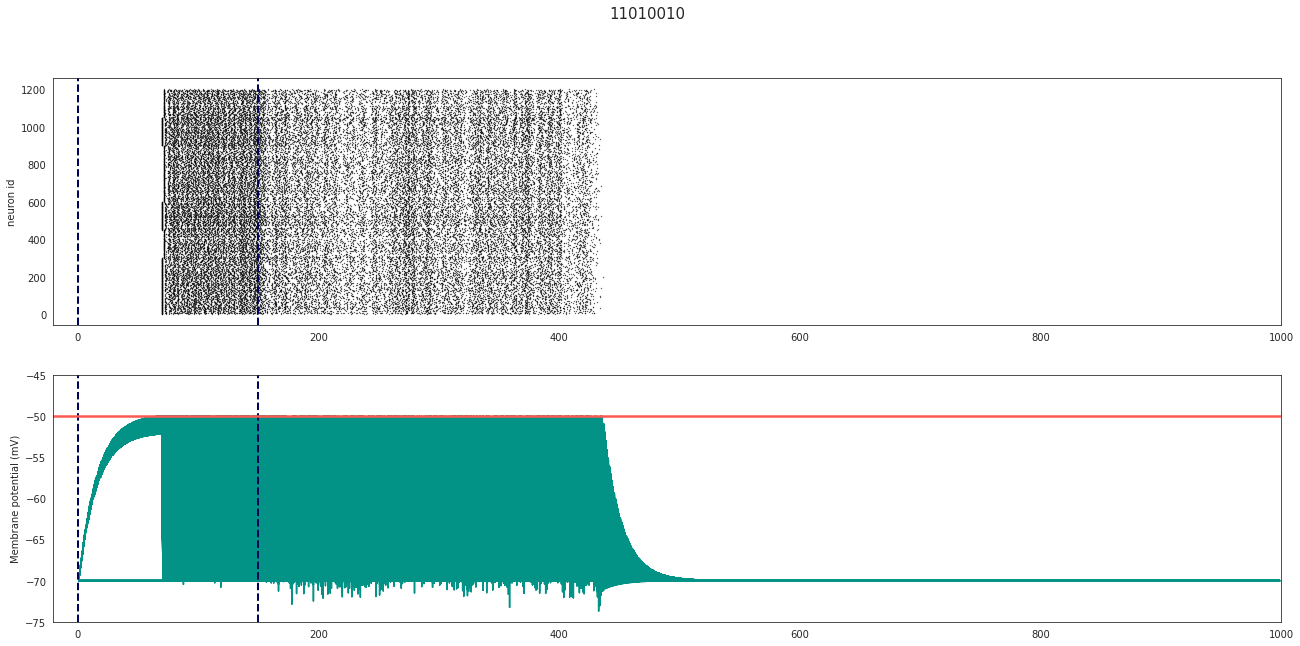

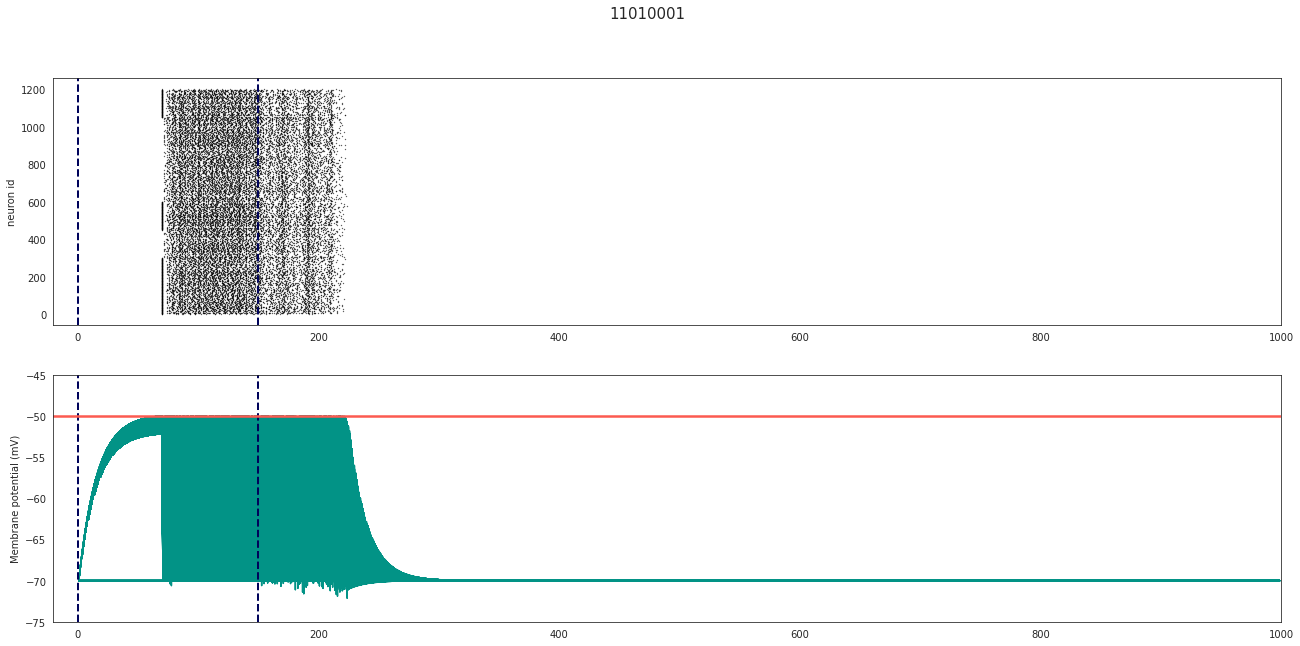

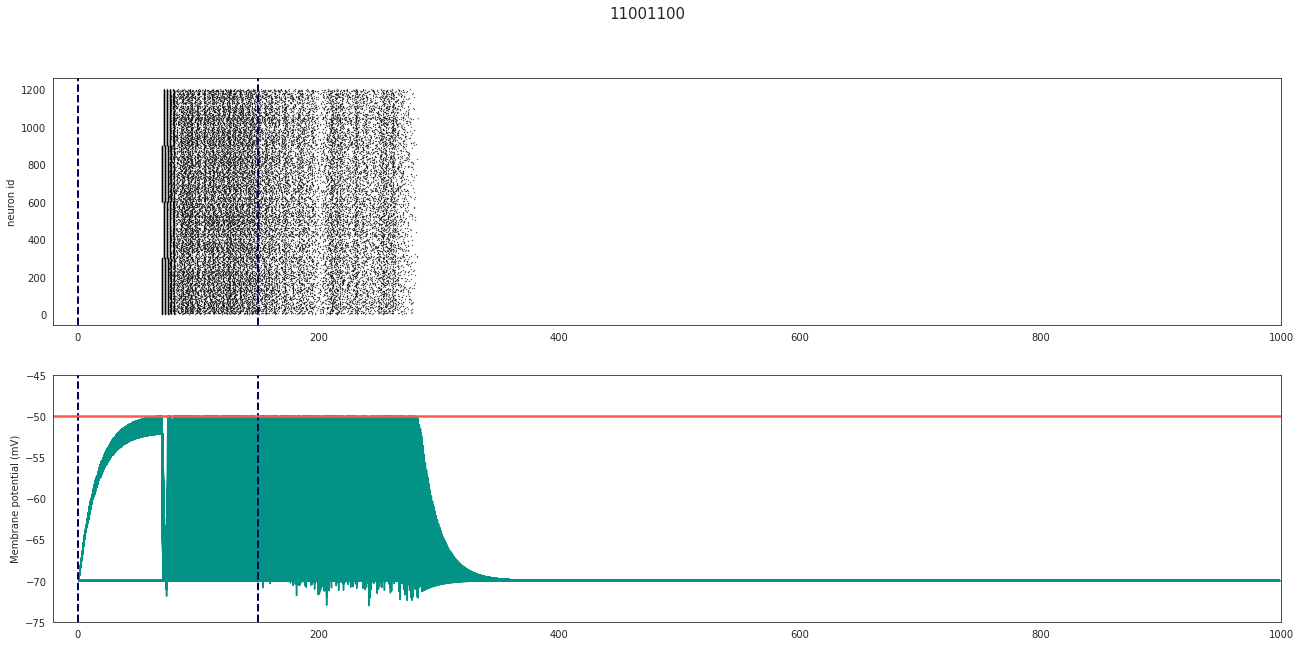

In [141]:
for i, pattern in enumerate(patterns[:10]): # show subset of patterns
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(22,10))
    plt.suptitle(U.list2str(pattern), size=15)
    # raster plot
    ax1.scatter(spike_times_lst[i], spike_neurons_lst[i], marker='o', s=0.08, color='k');
    ax1.set_ylabel('neuron id')
    ax1.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.axvline(x=150., linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.set_xlim([-20, 1000])

    # voltage
    ax2.plot(times_lst[i], events_lst[i]['V_m'], color='xkcd:teal')
    ax2.set_ylabel('Membrane potential (mV)')
    ax2.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axvline(x=150., linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axhline(y=-50, linewidth=2.5, color='xkcd:coral', linestyle='-')
    ax2.set_xlim([-20, 1000])
    ax2.set_ylim([-75, -45]);

## 5 Measure spiking activity

- **Average firing rate.** The number of spikes per second.
    - per neuron
    - population
- **Spike histogram.** Displays changes in network activity over time.


In [142]:
# get firing rates for all patterns
fr_pop_lst = []
fr_per_neuron_lst = []


for i in range(len(spike_times_lst)):
    
    fr_pop, fr_per_neuron = U.average_firing_rate(spike_times_lst[i])
    fr_pop_lst.append(fr_pop)
    fr_per_neuron_lst.append(fr_per_neuron)

#print(fr_per_neuron_lst)

# convert to arrays
fr_per_neuron_arr = np.array(fr_per_neuron_lst)
fr_pop_arr = np.array(fr_pop_lst)

# averaging list of lists
TOTAL_fr_per_neuron = round(np.mean(fr_per_neuron_arr, axis=0),2)
TOTAL_fr_pop = round(np.mean(fr_pop_arr, axis=0),2)

print(f'Average firing rate per neuron: {TOTAL_fr_per_neuron}')
print(f'Average firing rate for entire population {TOTAL_fr_pop}')

Average firing rate per neuron: 24.7
Average firing rate for entire population 29641.59


In [143]:
# lots of synchronous activity --> barely have interspike intervals
ISI = U.interspike_intervals(spike_times_lst[3])

ISI

array([ 0. ,  0. ,  0. , ...,  0.3,  0.1, -0.4])

## Part II. Find critical parameter ranges

- `transient_spikes` is the total number of spikes in a transient.
- `transient_size` is the number of unique neurons that spiked in a transient.
- `transient_lifetime` is the duration of the transient in ms.

`transient_spikes` and `transient_size` most of the time identical so here I will be just looking at 

`transient_size` and `transient_lifetime`

In [144]:
range_J_ex = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4] # default value: 6.0
range_J_in = [-55., -54., -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43., -42., -41., -40.]
range_stim_durations = [25., 50., 75., 100., 125., 150.]

### 1. Change `J_in` values 

In [145]:
# === set parameter you want to change ===
parameter_range = range_J_in

# ======= #
transient_mins = []
transient_means = []
transient_maxs = []

for x in parameter_range:
    
    # === set the parameters ===
    sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=x)
    
    # === initialise class with these parameters ===
    LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
    LS.build_network() # build network
    
    # === run the simulations ===
    multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(patterns)
    
    # === spoon out the data we need ===
    _, transient_lifetime, transient_size = get_transient_data(spike_times_lst, spike_neurons_lst, sim_params)
    # === get metrics ===
    mins, means, maxs = get_metrics(transient_size, transient_lifetime)

    # collect data 
    transient_mins.append(mins)
    transient_means.append(means)
    transient_maxs.append(maxs)

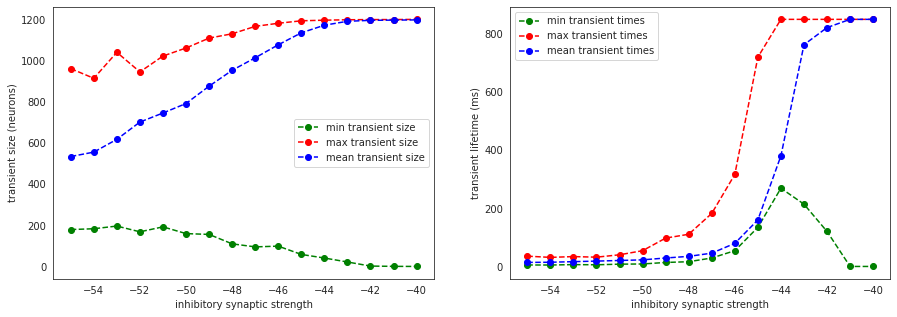

In [146]:
plot(transient_mins, transient_means, transient_maxs, 'inhibitory synaptic strength', range_J_in)

### 2. ratio inhibitory / excitatory neurons

In [147]:
range_NE_neurons = [1050, 1040, 1025, 1000, 950, 900, 850]
range_NI_neurons = [150, 160, 175, 200, 250, 300, 350]

ratio_inh = [0.12, 0.13, 0.15, 0.17, 0.20, 0.25, 0.29]

In [148]:
# === set parameter you want to change ===
parameter_range = range_NE_neurons

# ======= #
transient_mins = []
transient_means = []
transient_maxs = []

for i in range(len(parameter_range)):

    # === set the parameters ===
    I = range_NI_neurons[i]
    E = range_NE_neurons[i]
    sim_params, model_params, syn_params_ex, syn_params_in = set_params(NI=I, NE=E)
    
    # === initialise class with these parameters ===
    LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
    LS.build_network() # build network
    
    # === run the simulations ===
    multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(patterns)
    
    # === spoon out the data we need ===
    _, transient_lifetime, transient_size = get_transient_data(spike_times_lst, spike_neurons_lst, sim_params)
    # === get metrics ===
    mins, means, maxs = get_metrics(transient_size, transient_lifetime)

    # collect data 
    transient_mins.append(mins)
    transient_means.append(means)
    transient_maxs.append(maxs)

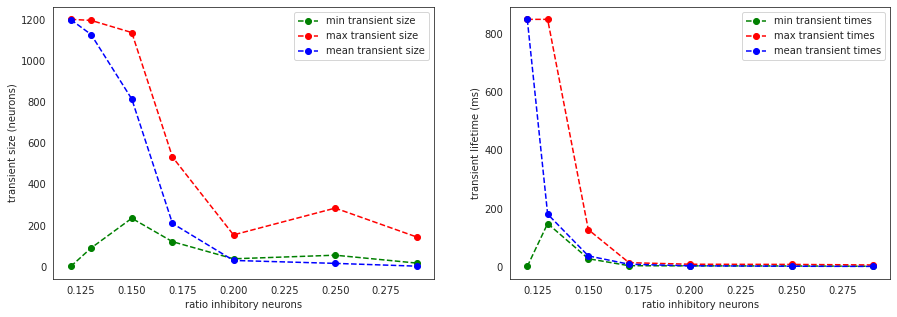

In [25]:
plot(transient_mins, transient_means, transient_maxs, 'ratio inhibitory neurons', ratio_inh)

### 3. Changing the stimulation time (`stim_end`)

In [26]:
# === set parameter you want to change ===
parameter_range = range_stim_durations 

# ======= #
transient_mins = []
transient_means = []
transient_maxs = []

for x in parameter_range:
    print(x)
    # === set the parameters ===
    sim_params, model_params, syn_params_ex, syn_params_in = set_params(stim_end=x)
    
    # === initialise class with these parameters ===
    LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
    LS.build_network() # build network
    
    # === run the simulations ===
    multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(patterns)
    
    # === spoon out the data we need ===
    _, transient_lifetime, transient_size = get_transient_data(spike_times_lst, spike_neurons_lst, sim_params)
    # === get metrics ===
    mins, means, maxs = get_metrics(transient_size, transient_lifetime)

    # collect data 
    transient_mins.append(mins)
    transient_means.append(means)
    transient_maxs.append(maxs)

25.0
50.0
75.0
100.0
125.0
150.0


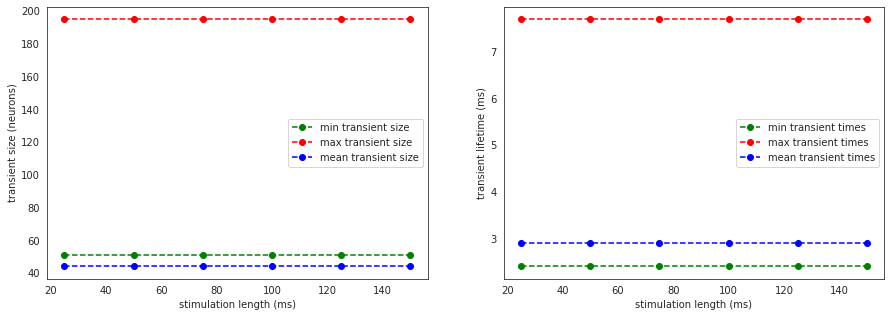

In [27]:
plot(transient_mins, transient_means, transient_maxs, 'stimulation length (ms)', range_stim_durations )

## Functions

In [154]:
def simulate_all(patterns):

    spikedet_lst = []
    multimet_lst = []

    spike_times_lst = []
    spike_neurons_lst = []
    events_lst = []
    times_lst = []

    for i, p in enumerate(patterns):
        #print(i,p)
        LS.set_pattern(p)

        spikedet, multimet, spike_times, spike_neurons, events, etimes = LS.simulate() 
        spikedet_lst.append(spikedet)
        multimet_lst.append(multimet)
        spike_times_lst.append(spike_times)
        spike_neurons_lst.append(spike_neurons)
        events_lst.append(events)
        times_lst.append(etimes)
        
    return multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst


def get_transient_data(spike_times_arr, spike_neurons_arr, sim_params):
    '''
    Uses the information from the simulation run to get information about the transient.
    '''
    # convert to np arrays
    spike_times_arr = np.array(spike_times_lst)
    spike_neurons_arr = np.array(spike_neurons_lst)
    
    transient_spikes = []
    transient_lifetime = []
    transient_uniquen = []
    transient_time_arr = []
    
    stim_end = sim_params['stim_end']
    
    for trial in range(len(spike_times_arr)):

        # select data from experiment / trial
        times = spike_times_arr[trial]
        neurons = spike_neurons_arr[trial]

        # === number of spikes ===
        num_trans_spikes = sum(1*(times > stim_end))
        transient_spikes.append(num_trans_spikes)

        # === transient lifetime ===
        transient_time = times[times > stim_end]
        transient_time_arr.append(transient_time)

        if num_trans_spikes == 0:
            transient_lifetime.append(0)
        else:
            t_dur = round(max(transient_time_arr[trial]) - stim_end,2)
            transient_lifetime.append(t_dur)

        # === transient_size ===
        transients = 1*(times > stim_end)
        transient_indices = np.argwhere(transients)
        # take the neurons from these indices
        active_neurons = np.unique(neurons[transient_indices])
        transient_uniquen.append(active_neurons)

    transient_size = [len(i) for i in transient_uniquen]
    
    return transient_spikes, transient_lifetime, transient_size


def get_metrics(transient_size, transient_lifetime):
    
    df = pd.DataFrame({'transient_size':transient_size, 'transient_lifetime':transient_lifetime})
    
    mins = df.std().tolist()
    means = df.mean().tolist()
    maxs = df.max().tolist()
    
    return mins, means, maxs

def plot(transient_mins, transient_means, transient_maxs, x_axis_name, parameter_range):
    '''
    takes in a list of transient means and max values, name for the x_axis (the parameter value that is being changed) 
    and the range of parameter values used.
    
    Plots the graphs.
    '''
    # [mean transient size, mean transient lifetime]
    trans_size_mins = [i[0] for i in transient_mins]
    trans_lifetime_mins = [i[1] for i in transient_mins]
    
    trans_size_means = [i[0] for i in transient_means]
    trans_lifetime_means = [i[1] for i in transient_means]    

    trans_size_maxs = [item[0] for item in transient_maxs]
    trans_lifetime_maxs = [item[1] for item in transient_maxs]

    # === Plot ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.plot(parameter_range, trans_size_mins, '--go', label='min transient size');
    ax1.plot(parameter_range, trans_size_maxs, '--ro', label ='max transient size');
    ax1.plot(parameter_range, trans_size_means, '--bo', label='mean transient size');
    ax1.set_xlabel(x_axis_name)
    ax1.set_ylabel('transient size (neurons)')
    ax1.legend();
    
    ax2.plot(parameter_range, trans_lifetime_mins, '--go', label ='min transient times');
    ax2.plot(parameter_range, trans_lifetime_maxs, '--ro', label ='max transient times');
    ax2.plot(parameter_range, trans_lifetime_means, '--bo', label='mean transient times');
    ax2.set_xlabel(x_axis_name);
    ax2.set_ylabel('transient lifetime (ms)')
    ax2.legend();
    

def show_rasters(pattern, spike_times, spike_neurons, times, events, stim_end):
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(22,10))
    plt.suptitle(U.list2str(pattern), size=15)
    # raster plot
    ax1.scatter(spike_times, spike_neurons, marker='o', s=0.08, color='k');
    ax1.set_ylabel('neuron id')
    ax1.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.axvline(x=stim_end, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax1.set_xlim([-20, 1000])

    # voltage
    ax2.plot(times, events['V_m'], color='xkcd:teal')
    ax2.set_ylabel('Membrane potential (mV)')
    ax2.axvline(x=0, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axvline(x=stim_end, linewidth=2., color='xkcd:dark blue', linestyle='--')
    ax2.axhline(y=-50, linewidth=2.5, color='xkcd:coral', linestyle='-')
    ax2.set_xlim([-20, 1000])
    ax2.set_ylim([-75, -45]);
    
    
def show_distributions(transient_spikes, transient_lifetime, transient_size):
    # to show the distributions
    d = {'transient_spikes':transient_spikes, 'transient_lifetime':transient_lifetime, 'transient_size':transient_size}
    df = pd.DataFrame(data=d)
    
    # call regplot on each axes
    f, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
    f.suptitle('Number of spikes in transient and transient duration', size=15);
    
    sns.distplot(df['transient_spikes'], ax=ax1, color='xkcd:sea blue', kde=False, bins=15);
    ax1.set_xlabel('# transient spikes')
    ax1.set_ylabel('# experiments')
    
    sns.distplot(df['transient_lifetime'], ax=ax2, color='xkcd:fire engine red', kde=False, bins=15);
    ax2.set_xlabel('# transient lifetime (ms)')
    ax2.set_ylabel('# experiments')
    

## Part III. Distributions

From the plots above, there is a big increase in transient lifetime from `J_in = [-46, -43]`. Initialise class with parameters in this range and observe the distributions.

## 3.1 Distributions with `J_in = -45`

In [78]:
# set the parameters
sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=-45., J_ex=6.)

# initialise class with parameter set and build network
LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
LS.build_network() 

# run simulations
multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(patterns)

# distributions
transient_spikes, transient_lifetime, transient_size = get_transient_data(spike_times_lst, spike_neurons_lst, sim_params)

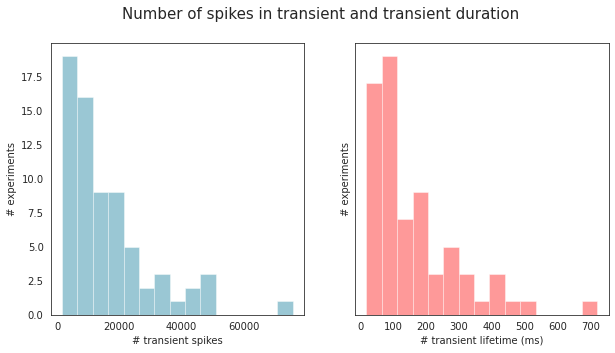

In [79]:
show_distributions(transient_spikes, transient_lifetime, transient_size)

## 3.2 Distributions with `J_in = -46`

In [82]:
# set the parameters
sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=-46., J_ex=6.)

# initialise class with parameter set and build network
LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
LS.build_network() 

# run simulations
multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(patterns)

# distributions
transient_spikes, transient_lifetime, transient_size = get_transient_data(spike_times_lst, spike_neurons_lst, sim_params)

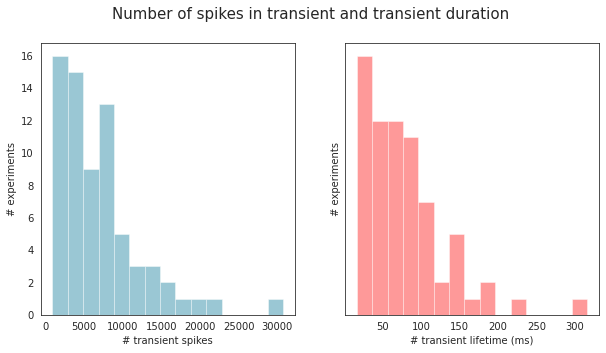

In [83]:
show_distributions(transient_spikes, transient_lifetime, transient_size)

## 3.3 Distributions with `J_in = -44`

In [84]:
# set the parameters
sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=-44., J_ex=6.)

# initialise class with parameter set and build network
LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
LS.build_network() 

# run simulations
multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(patterns)

# distributions
transient_spikes, transient_lifetime, transient_size = get_transient_data(spike_times_lst, spike_neurons_lst, sim_params)

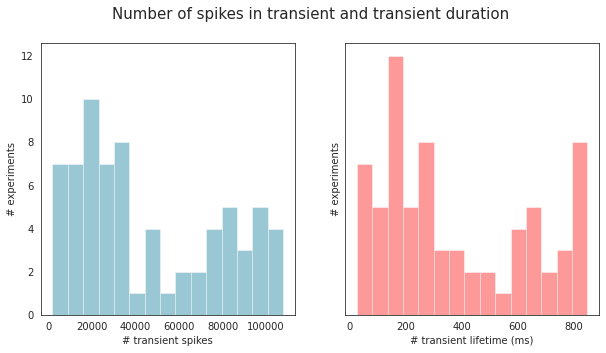

In [85]:
show_distributions(transient_spikes, transient_lifetime, transient_size)

## Part IV. STDP

`stdp_synapse` parameters as defined in [(Gutig et al., 2003)](https://www.jneurosci.org/content/jneuro/23/9/3697.full.pdf)

Parameter | unit | description
--- | --- | ---
$\tau_+$ | ms | Time constant of STDP window, potentiation (tau_minus defined in post-synaptic neuron)
$\lambda$ | real | step size / learning rate
$\alpha$ | real  | Asymmetry parameter (scales depressing increments as $\alpha*\lambda$)
$\mu_+$ | real | Weight dependence exponent, potentiation
$\mu_-$ | real | Weight dependence exponent, depression
$W_{max}$ | real | maximum allowed weight

we have
$$
\Delta w = \begin{cases} 
  -\lambda f_-(w) * \exp(-\frac{|\Delta t|}{\tau}) & if \Delta t \leq 0\\
  \lambda f_+(w) * \exp(-\frac{|\Delta t|}{\tau}) & if \Delta t > 0\\
\end{cases}
$$



Remark:
- the weight dependence exponent can be set separately for potentiation and depression.


[Random balanced network HPC benchmark](https://github.com/nest/nest-simulator/blob/master/pynest/examples/hpc_benchmark.py#L219)


$$
W(t) = 
$$

In [182]:
# default params for simple stdp model (Gutig et al., 2003)
nest.GetDefaults('stdp_synapse')

{'lambda': 0.01,
 'alpha': 1.0,
 'delay': 1.0,
 'has_delay': True,
 'mu_minus': 1.0,
 'mu_plus': 1.0,
 'num_connections': 0,
 'receptor_type': 0,
 'requires_symmetric': False,
 'sizeof': 96,
 'synapse_model': <SLILiteral: stdp_synapse>,
 'tau_plus': 20.0,
 'weight': 1.0,
 'weight_recorder': -1,
 'Wmax': 100.0}

In [203]:
# # default params from nest HPC benchmark
# STDP_syn_params = {
#     'model':'stdp_synapse', 
#     'delay': 1.5,
#     'alpha': 0.0513,
#     'lambda': 0.1,  # STDP step size
#     'mu_plus': 0.4,  # STDP weight dependence exponent(potentiation)
#     'tau_plus': 15.0,  # time constant for potentiation
#          }

In [204]:
my_exc_STDP_params = {
    'model':'stdp_synapse', 
    'delay': 1.0,
    'alpha': 0.0513,
    'lambda': 0.001,  # STDP step size
    'mu_plus': 0.01,  # STDP weight dependence exponent(potentiation)
    'tau_plus': 15.0,  # time constant for potentiation
    'weight':0.06
}

In [206]:
my_inh_STDP_params = {
    'model':'stdp_synapse', 
    'delay': 1.0,
    'alpha': 0.0513,
    'lambda': 0.001,  # STDP step size
    'mu_plus': 0.01,  # STDP weight dependence exponent(potentiation)
    'tau_plus': 15.0,  # time constant for potentiation
    'weight':-0.95,
    'Wmax': -1.0
}

##  patterns and shuffle 

In [193]:
patterns = []
# make permutations for 8 bit pattern
for i in range(2):
    for perm in U.make_permutations():
        patterns.append(perm)

In [186]:
patterns = random.shuffle(patterns)

In [187]:
# 3 x 5 patterns
p_subset = [[1, 1, 1, 0, 0, 0, 0, 1],[1, 1, 0, 1, 1, 0, 0, 0],[1, 1, 0, 1, 0, 1, 0, 0],[1, 1, 0, 1, 0, 0, 1, 0], 
            [1, 1, 0, 1, 0, 0, 0, 1],[1, 1, 1, 0, 0, 0, 0, 1],[1, 1, 0, 1, 1, 0, 0, 0],[1, 1, 0, 1, 0, 1, 0, 0],
            [1, 1, 0, 1, 0, 0, 1, 0],[1, 1, 0, 1, 0, 0, 0, 1], [1, 1, 1, 0, 0, 0, 0, 1],[1, 1, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 1, 0, 1, 0, 0],[1, 1, 0, 1, 0, 0, 1, 0],[1, 1, 0, 1, 0, 0, 0, 1]]

## 4.1 do STDP on excitatory synapses only

In [212]:
# set the parameters
sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=-45., J_ex=6.)

# choose a parameterisation for ex neurons
syn_params_ex = my_exc_STDP_params

# initialise class and buildnetwork
LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
LS.build_network(STDP='exc_only') 

In [213]:
# run simulations
multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(p_subset)

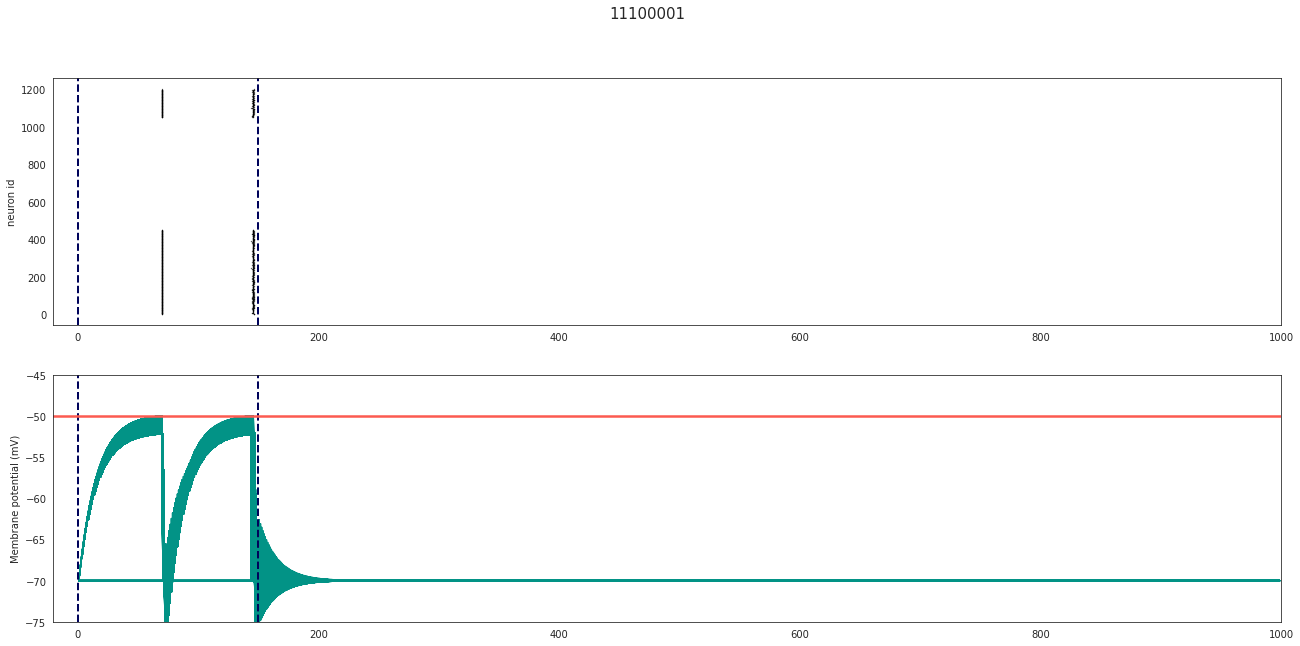

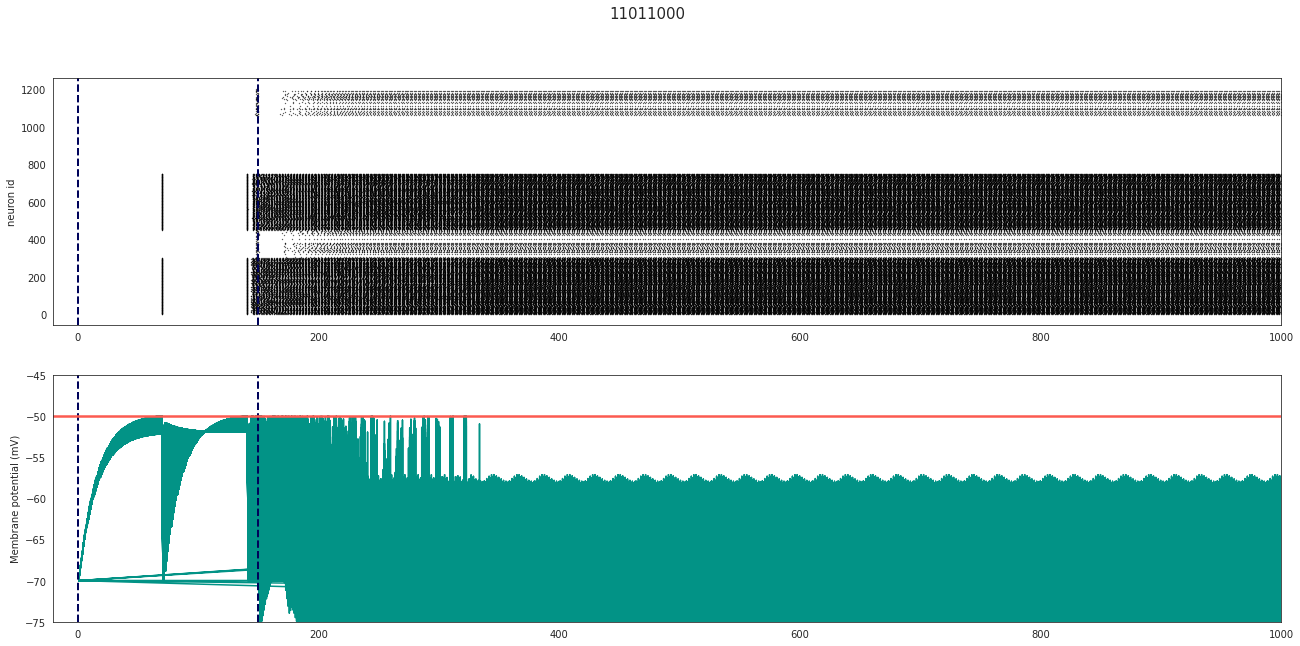

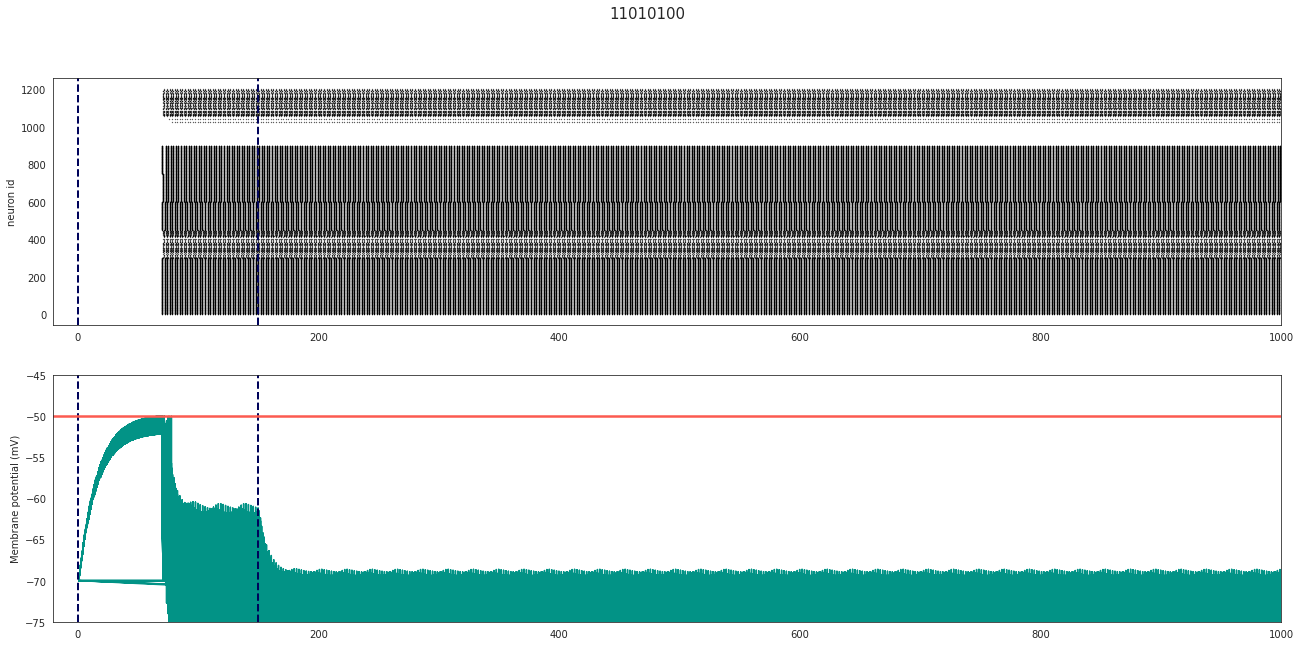

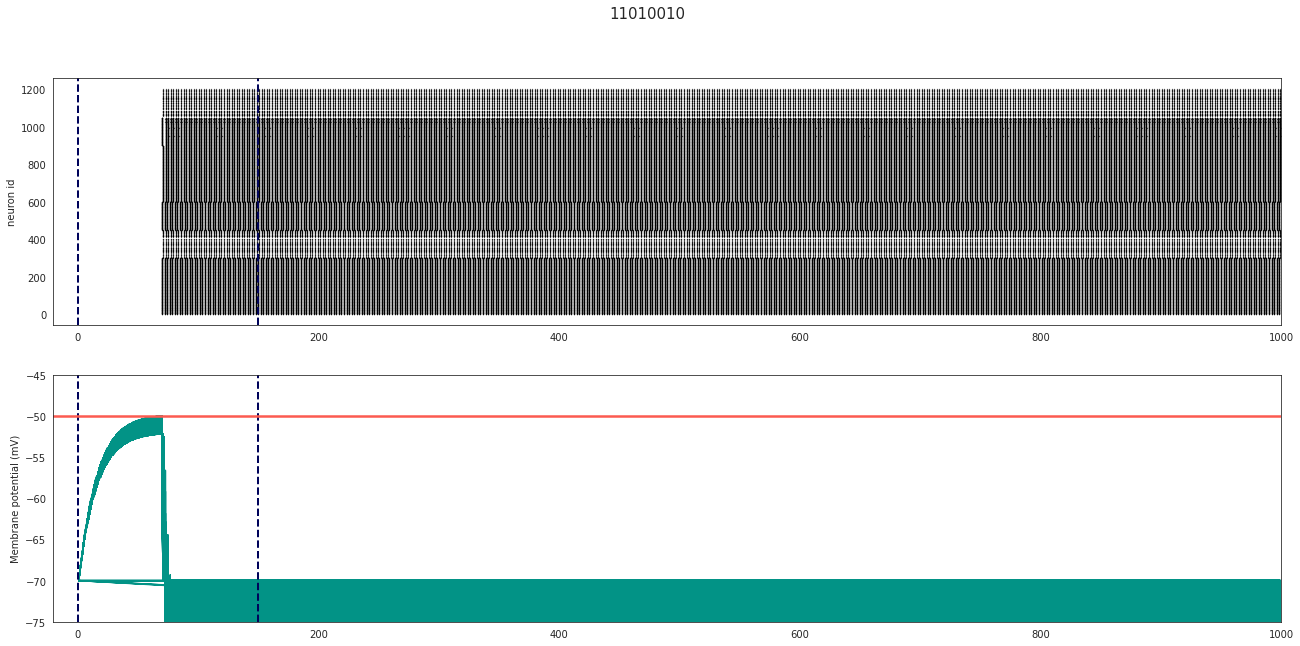

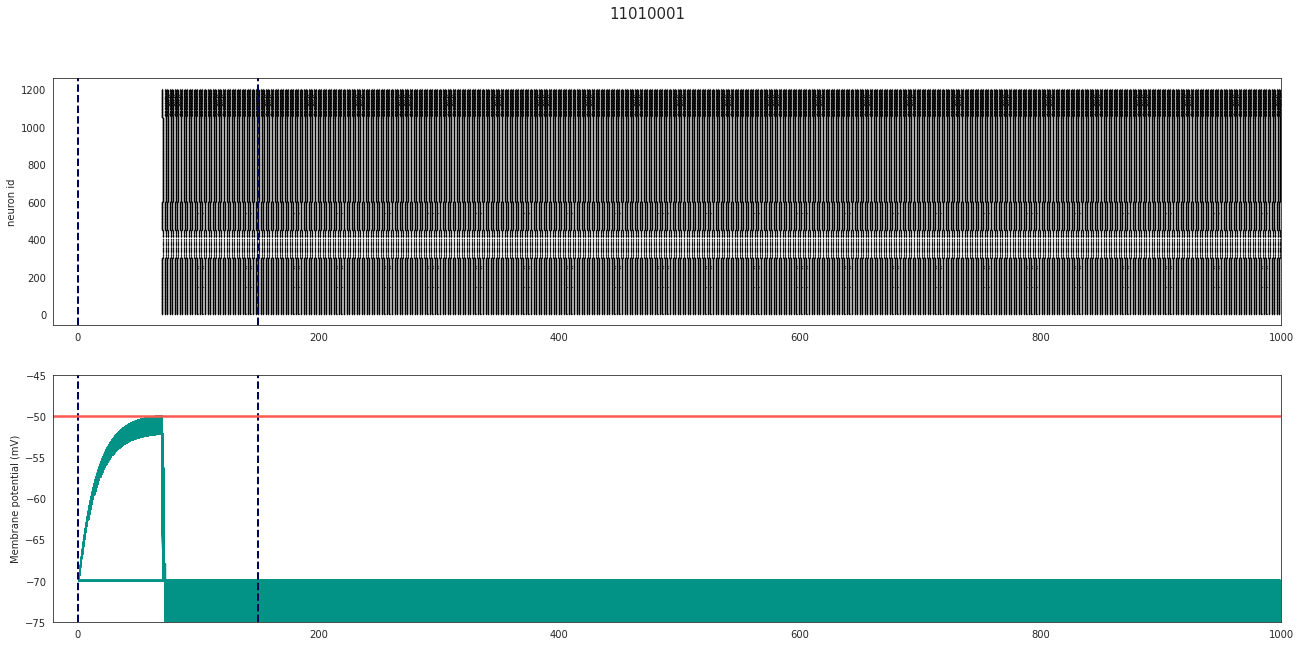

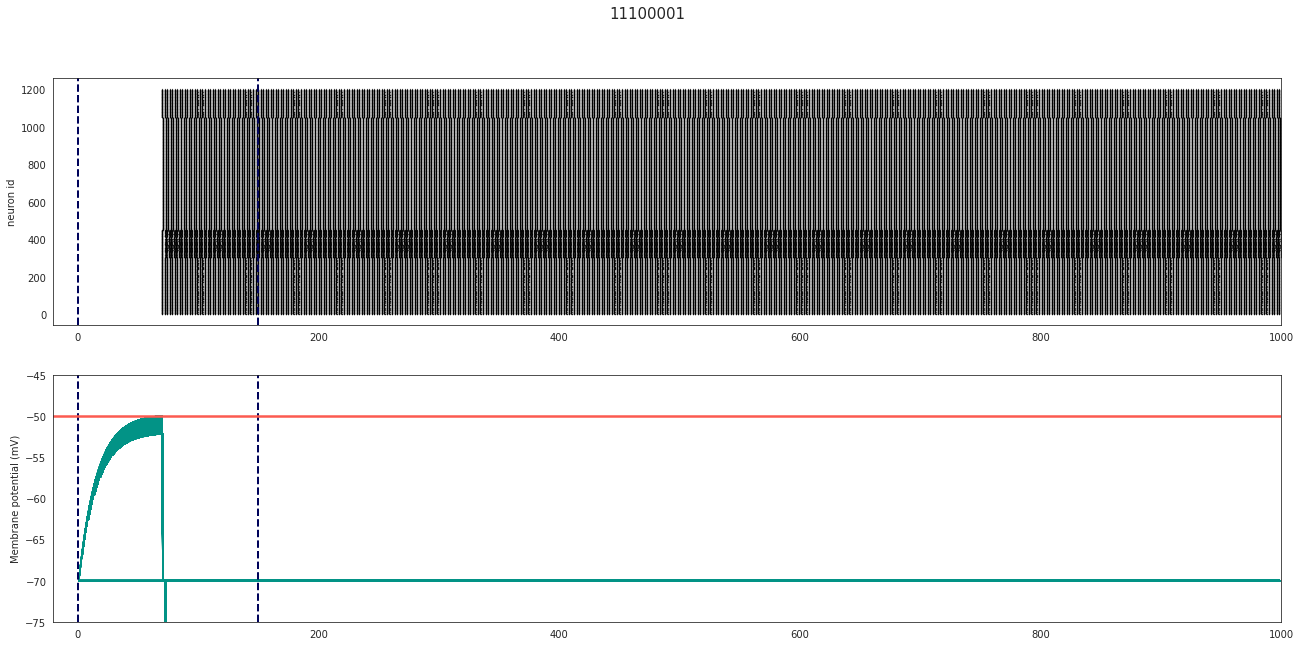

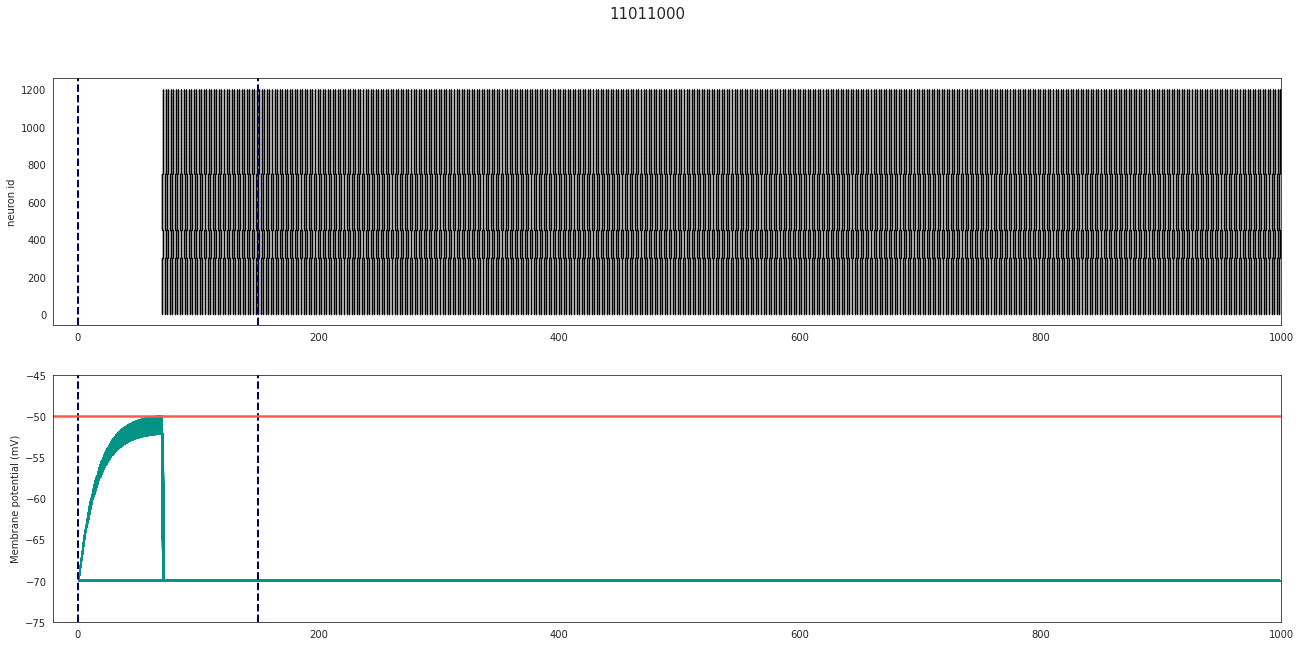

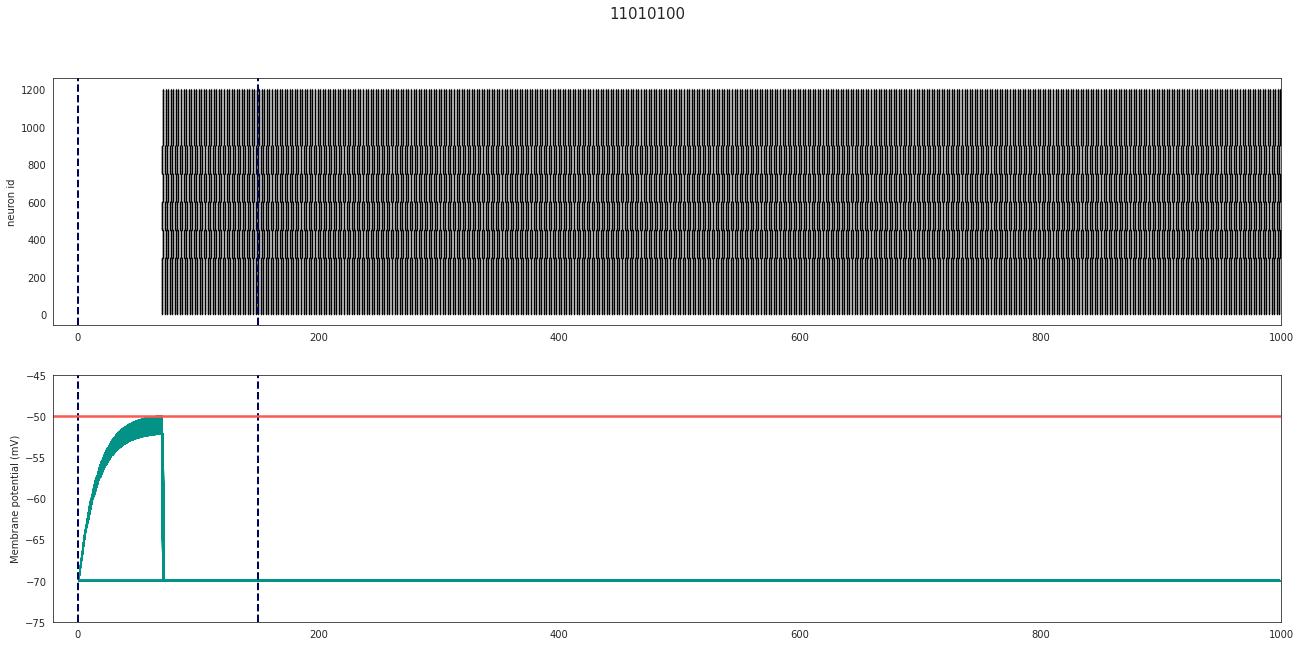

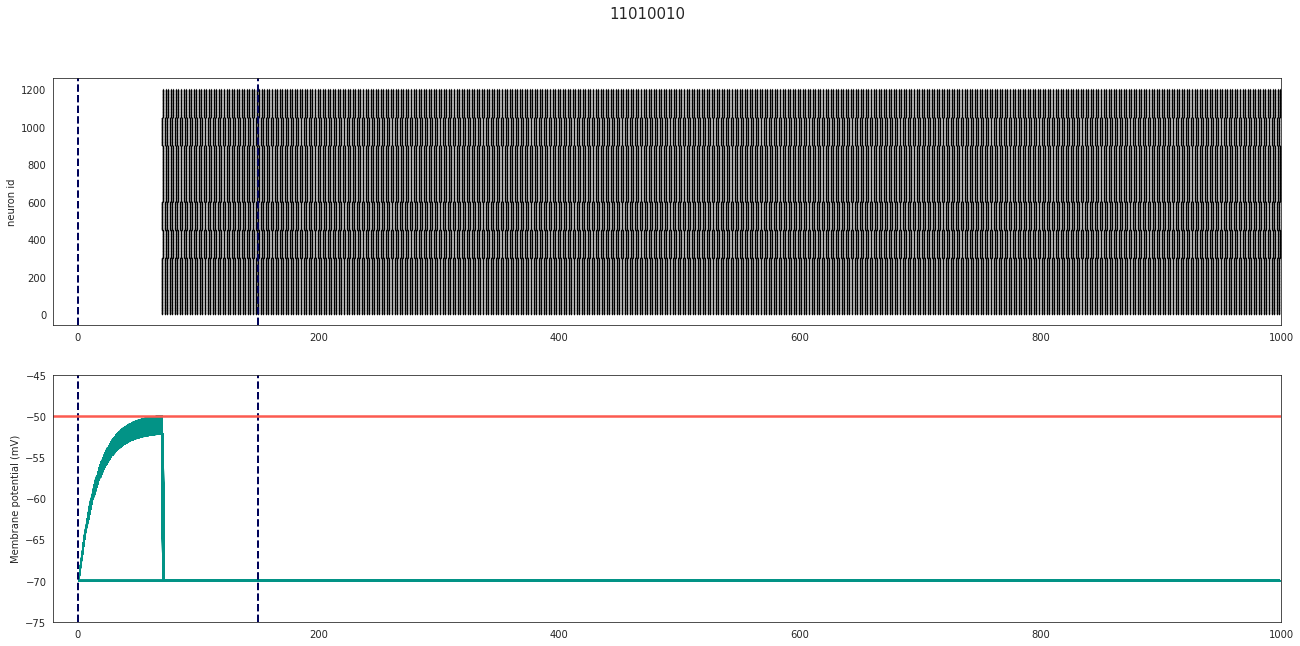

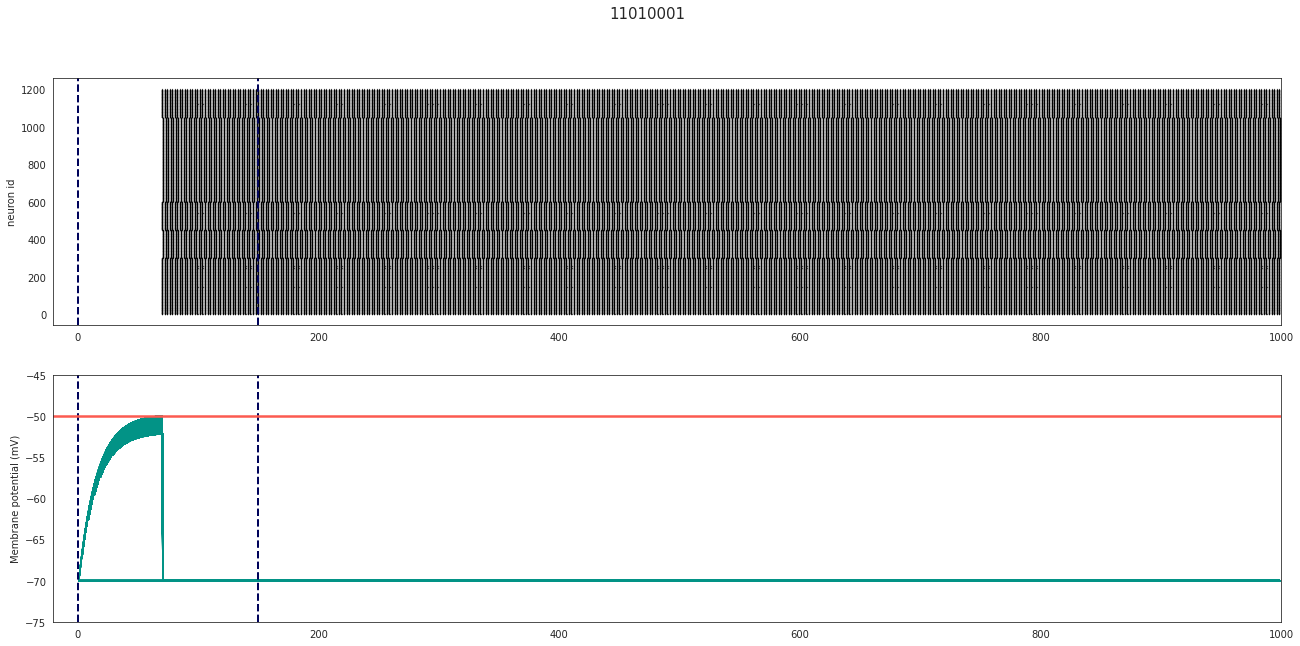

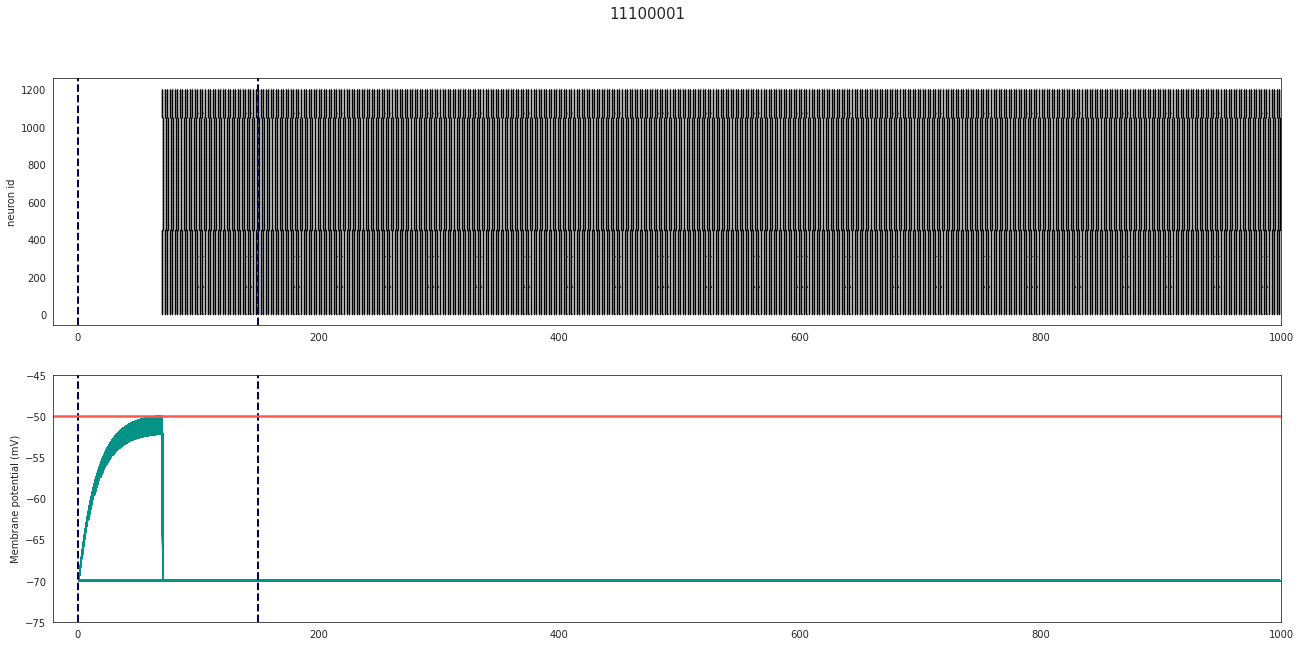

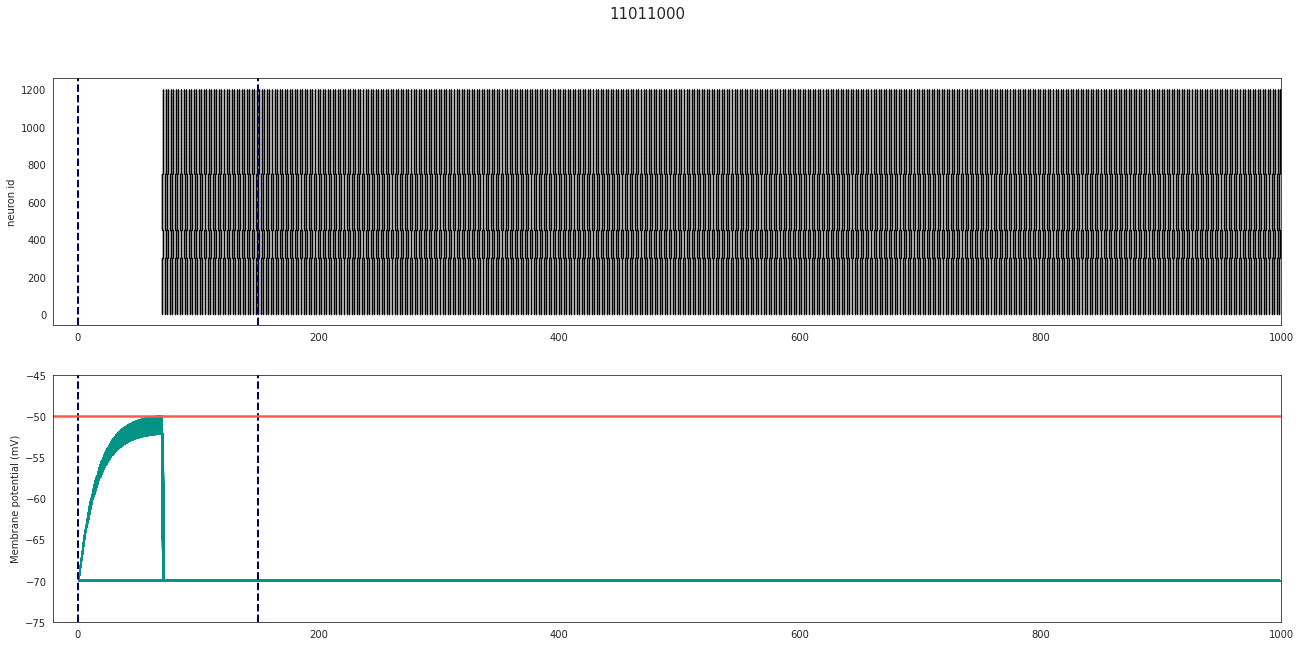

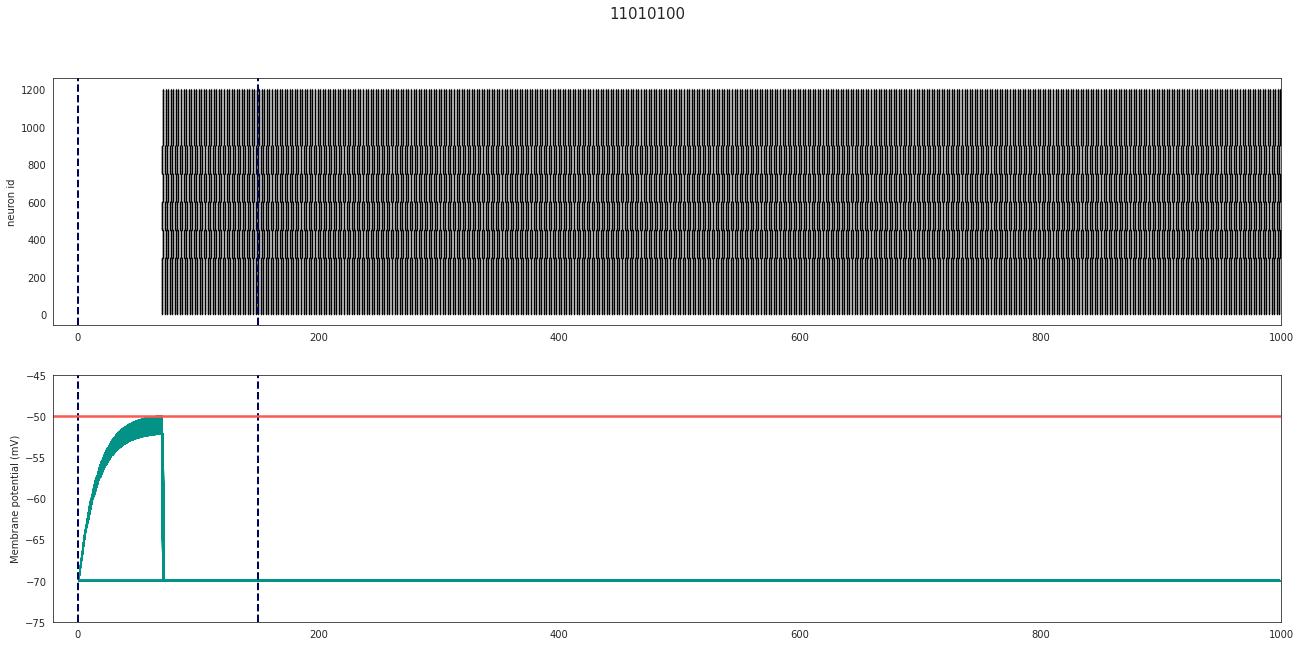

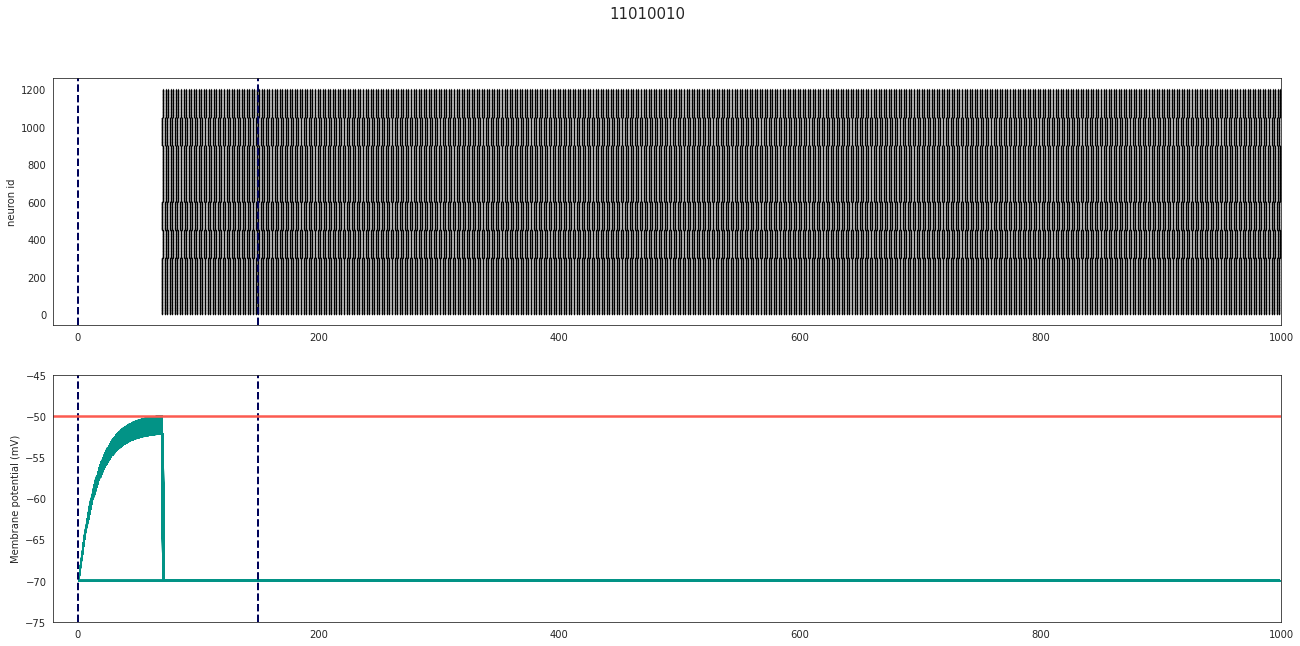

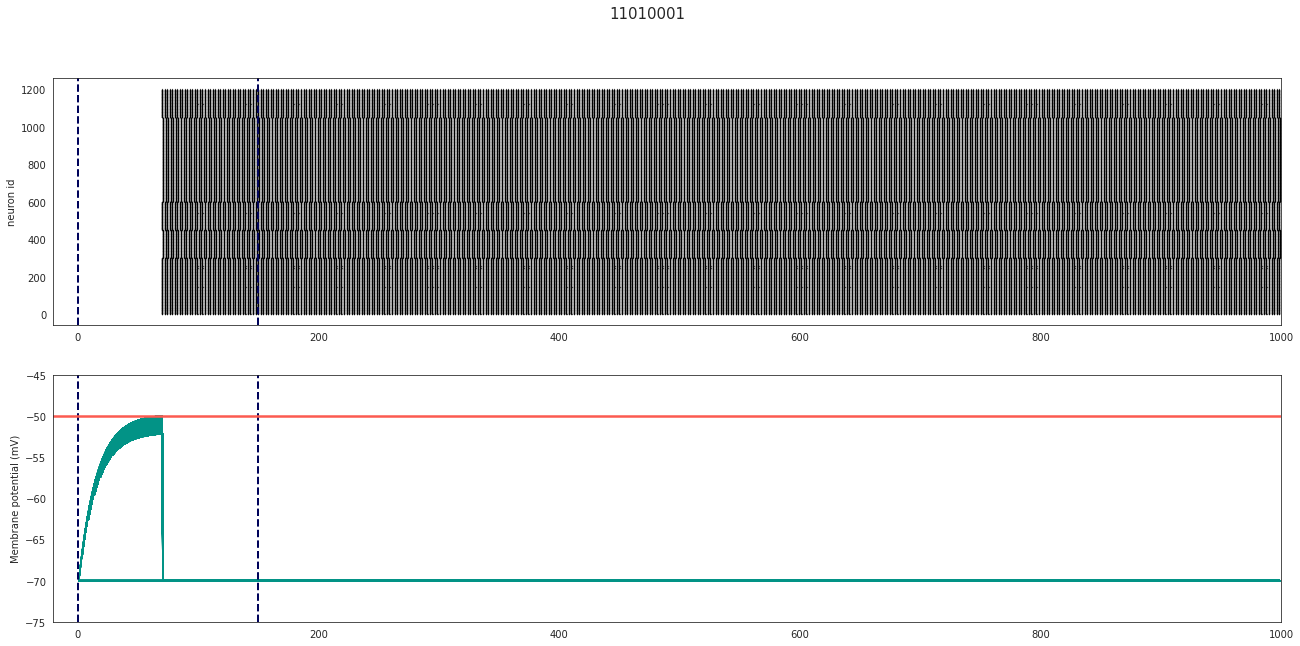

In [200]:
for i, p in enumerate(p_subset): 
    show_rasters(p, spike_times_lst[i], spike_neurons_lst[i], times_lst[i], events_lst[i], 150)

## 4.2 do STDP on all synapses

In [214]:
# set the parameters
sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=-45., J_ex=6.)

# change a parameterisations for synapses
syn_params_in = my_inh_STDP_params
syn_params_ex = my_exc_STDP_params

# initialise class and buildnetwork
LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
LS.build_network(STDP='all') 

In [215]:
# run simulations
multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_all(p_subset)

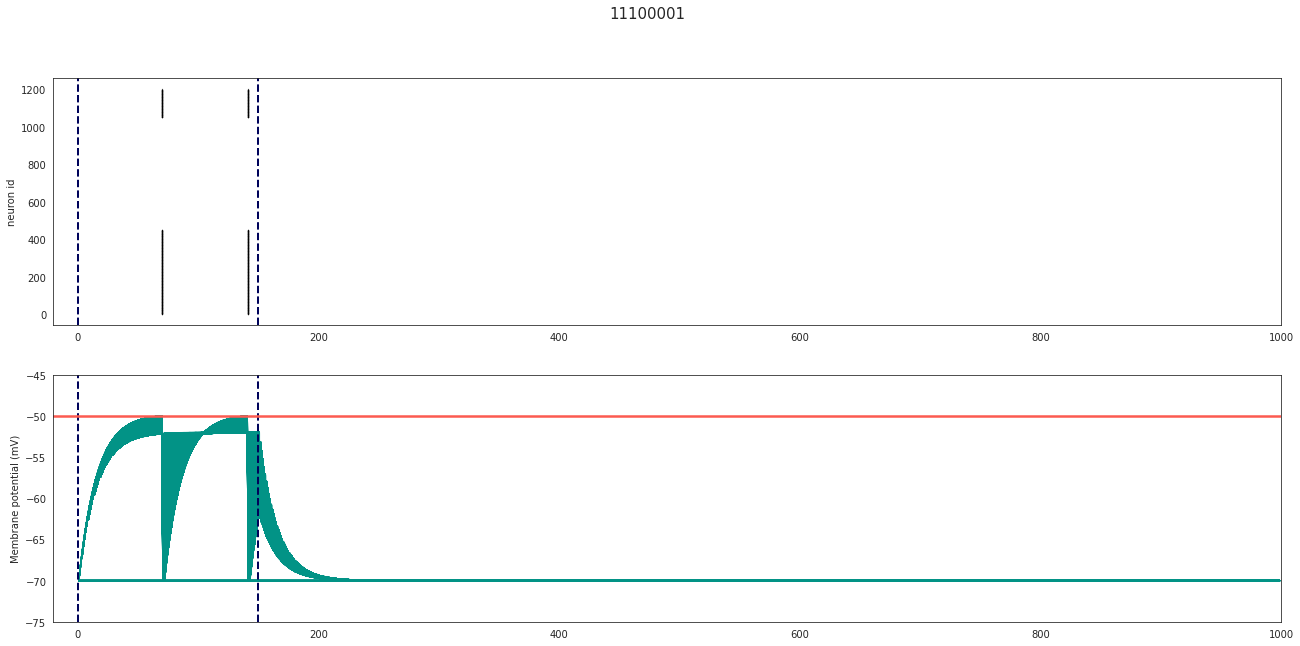

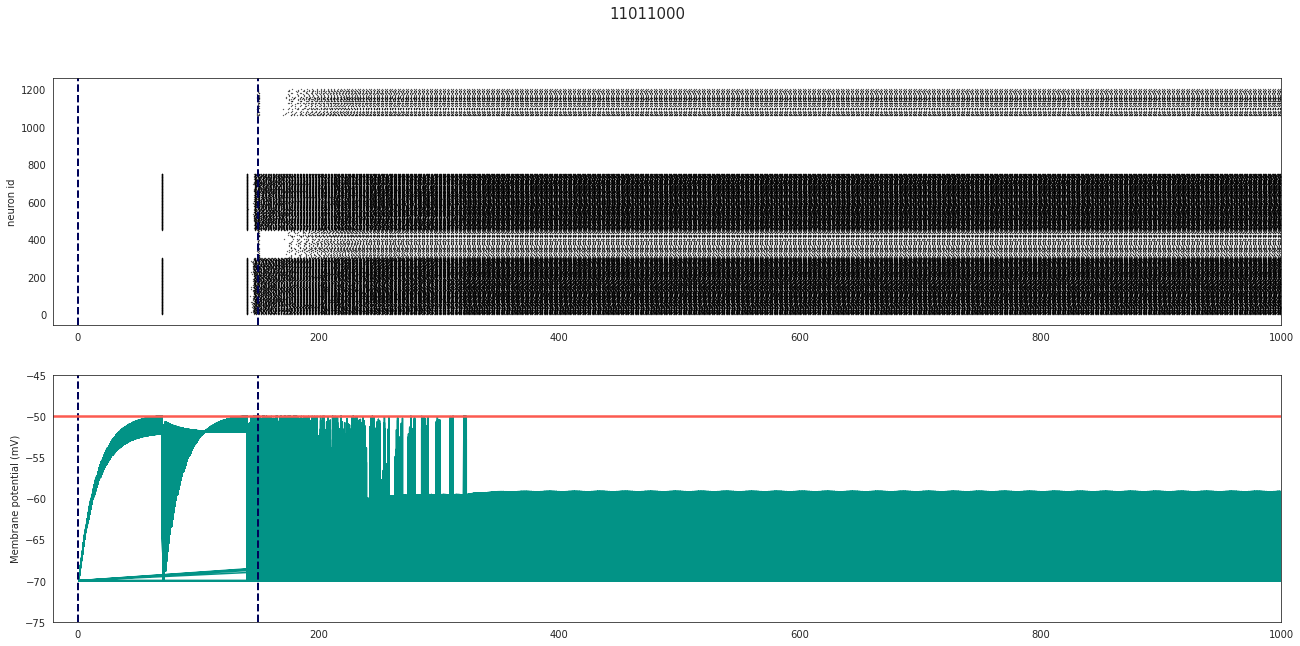

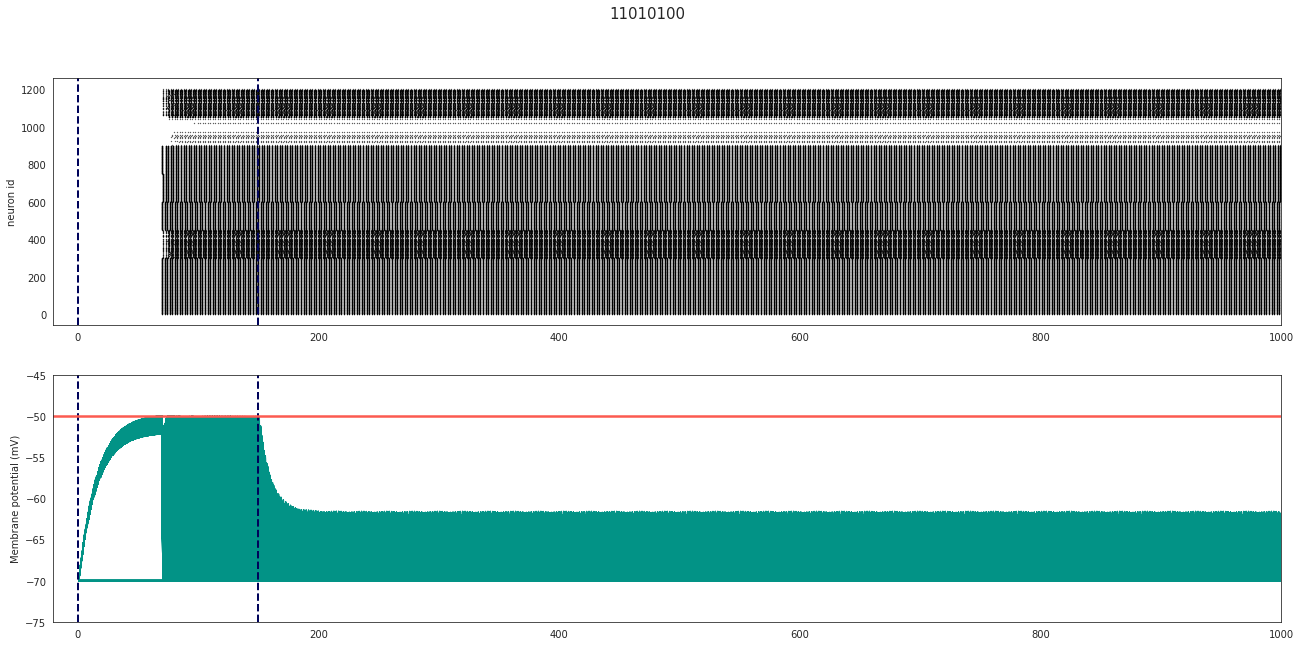

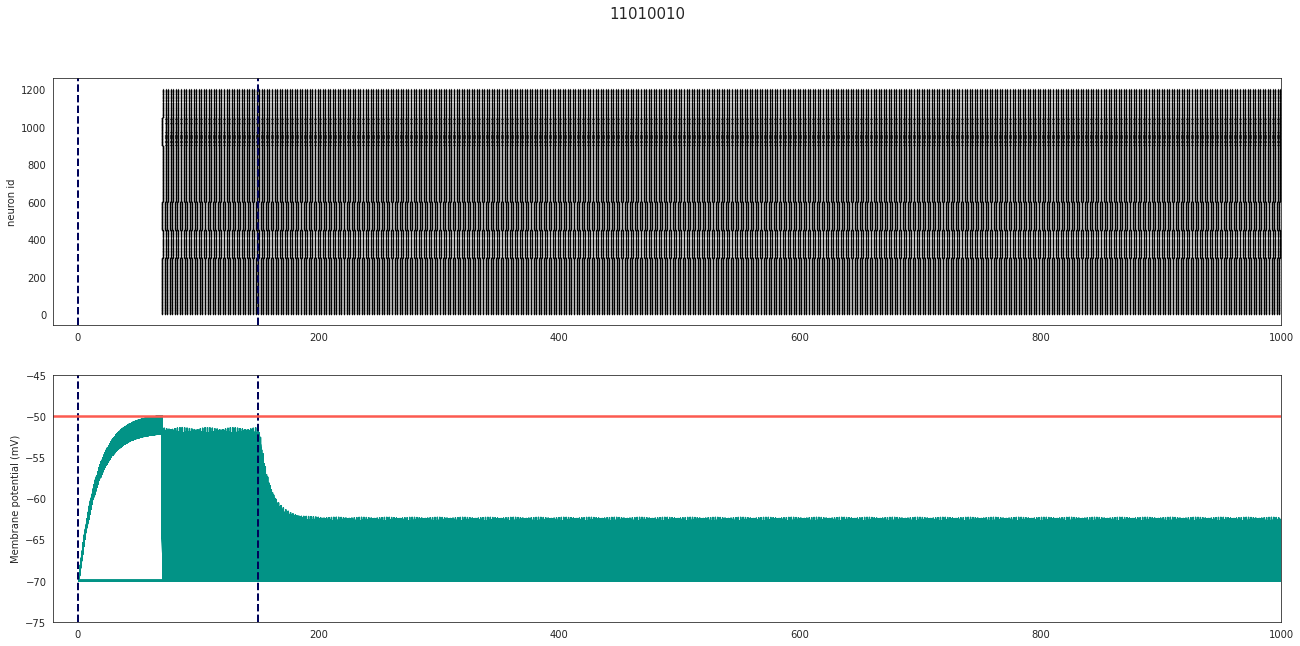

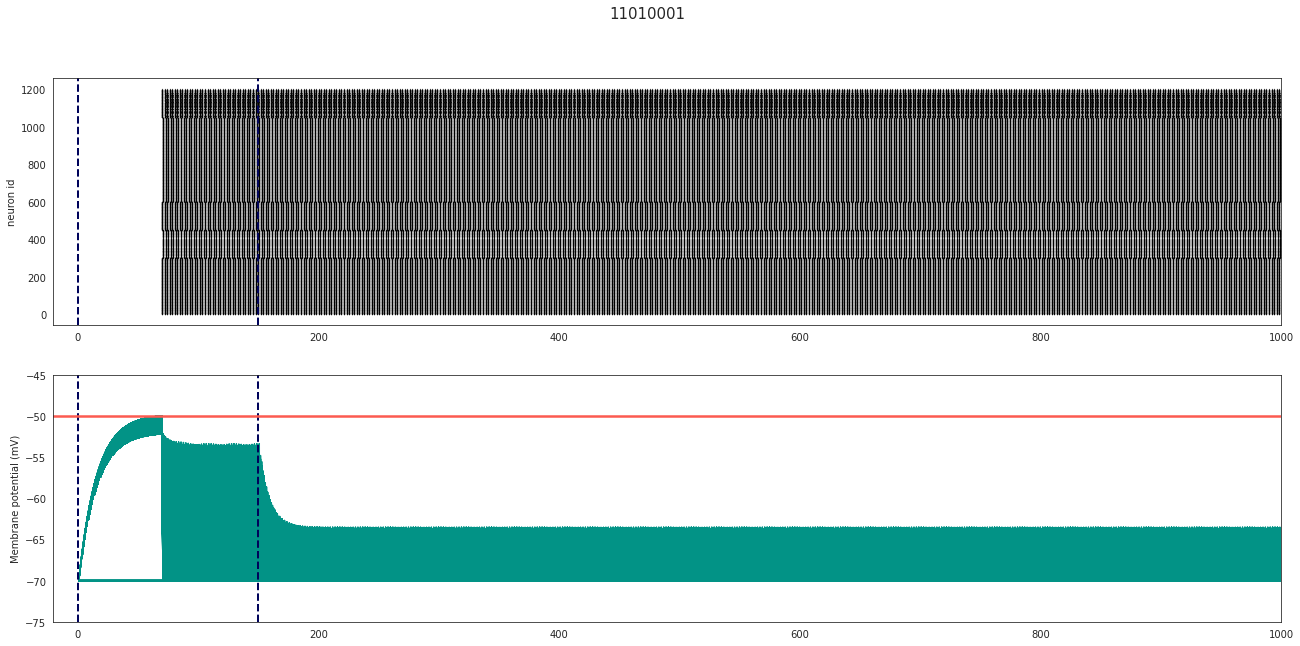

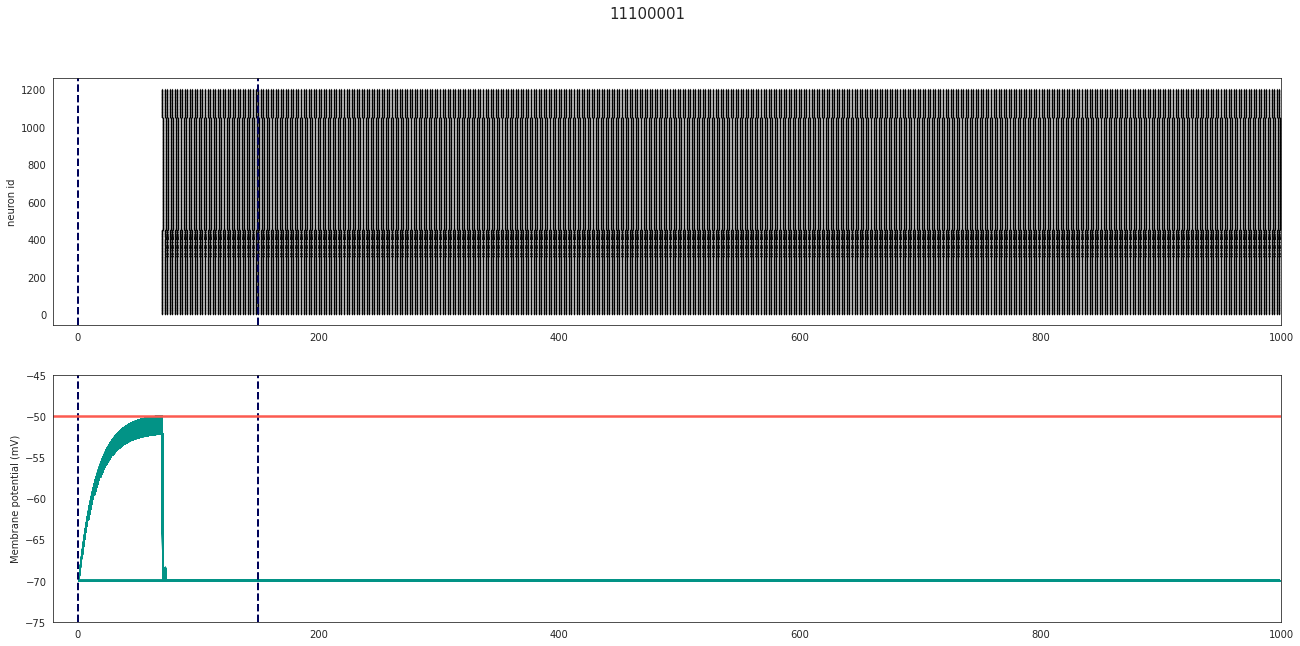

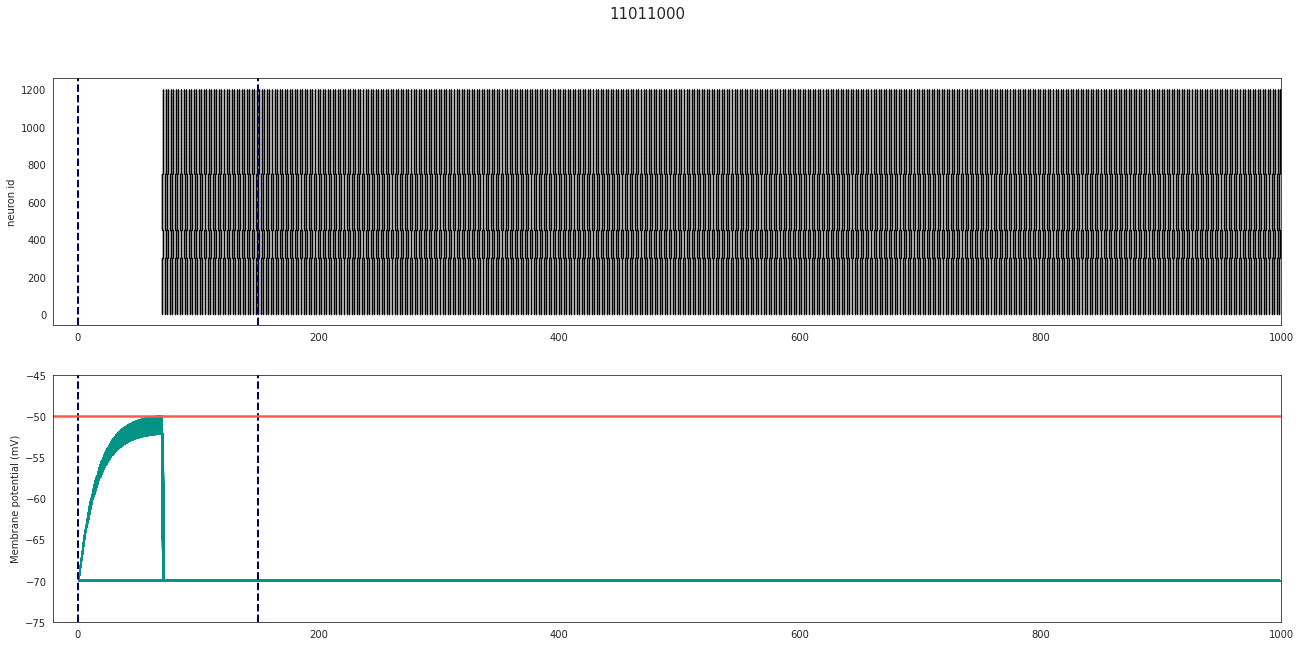

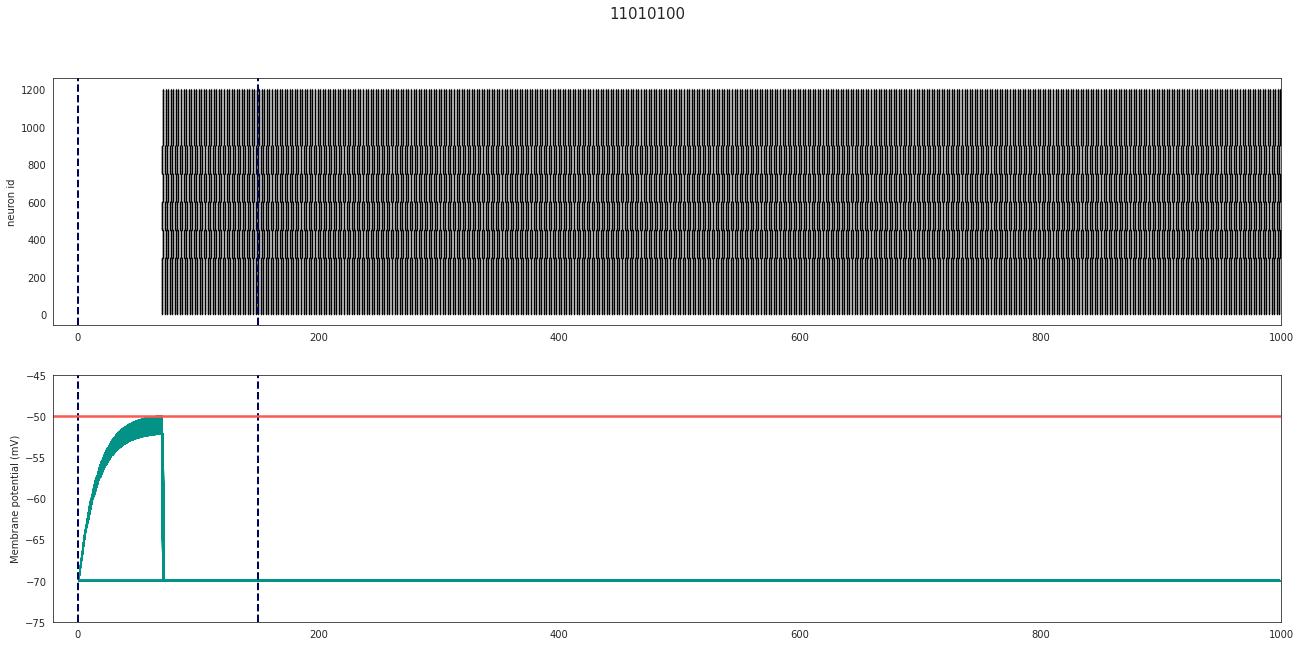

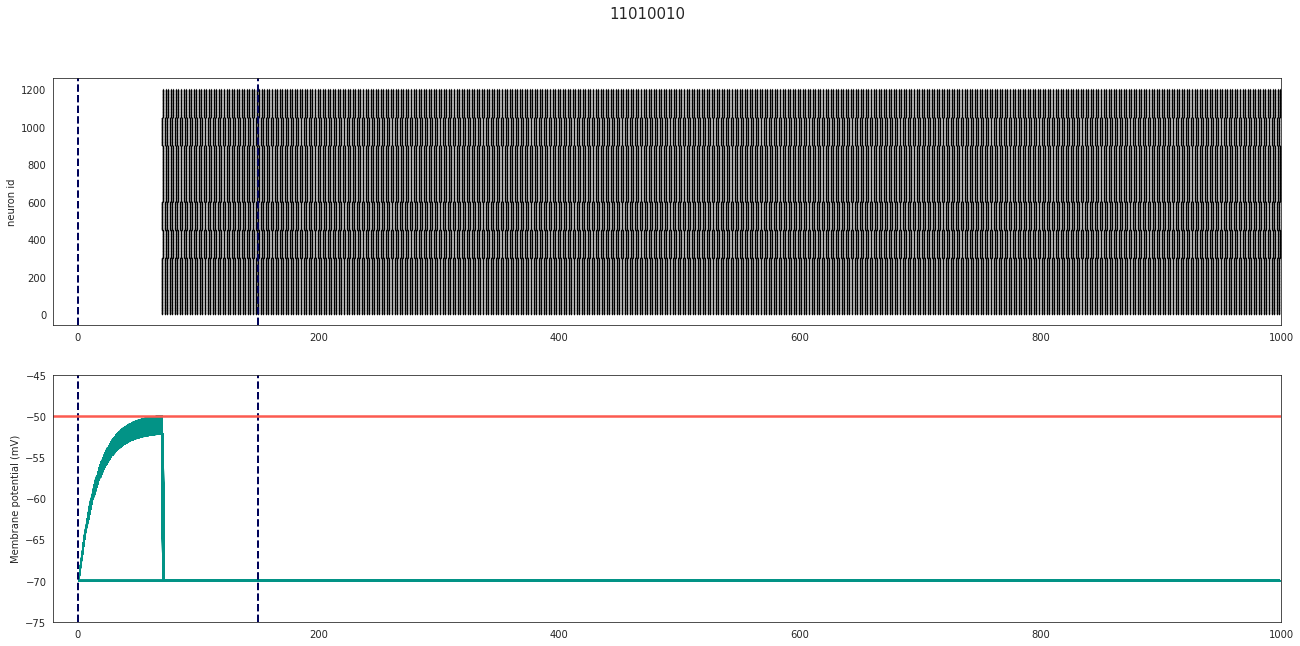

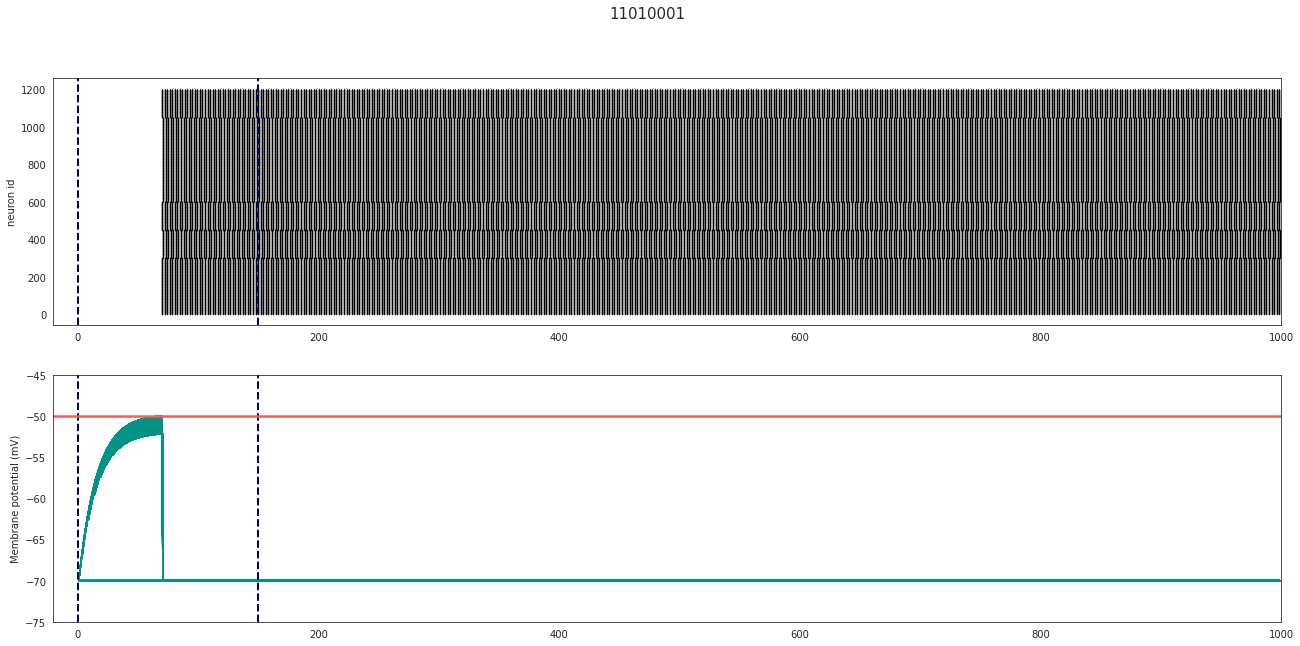

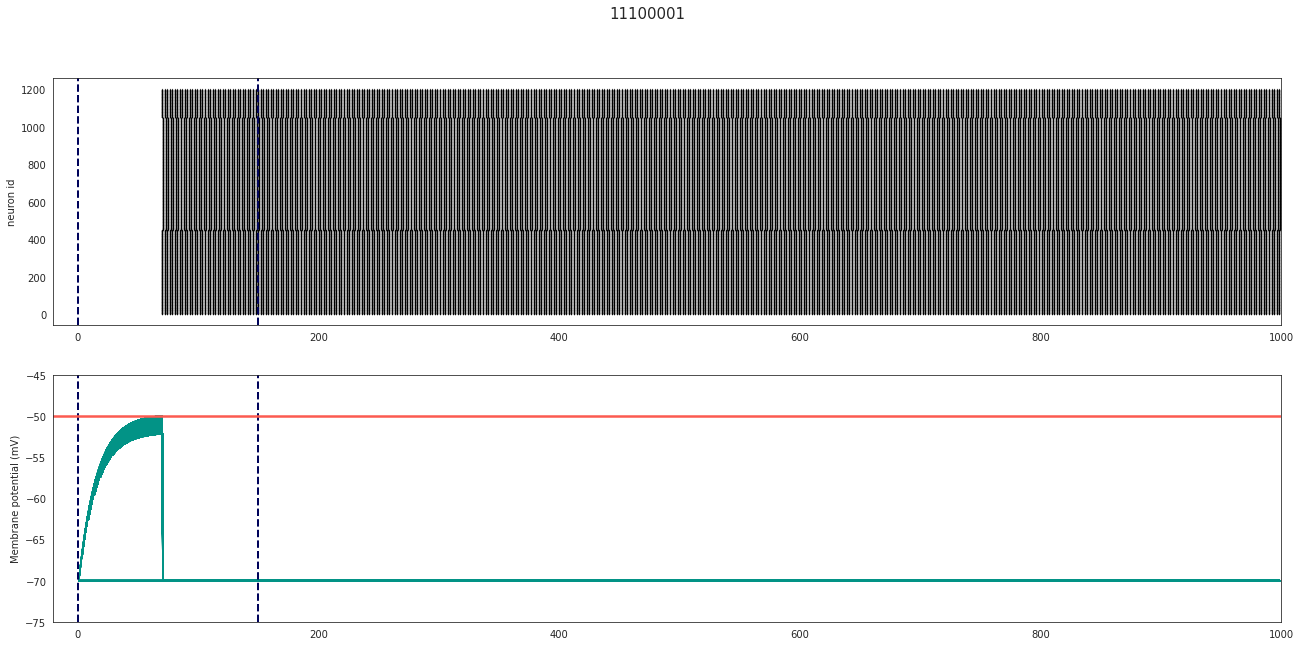

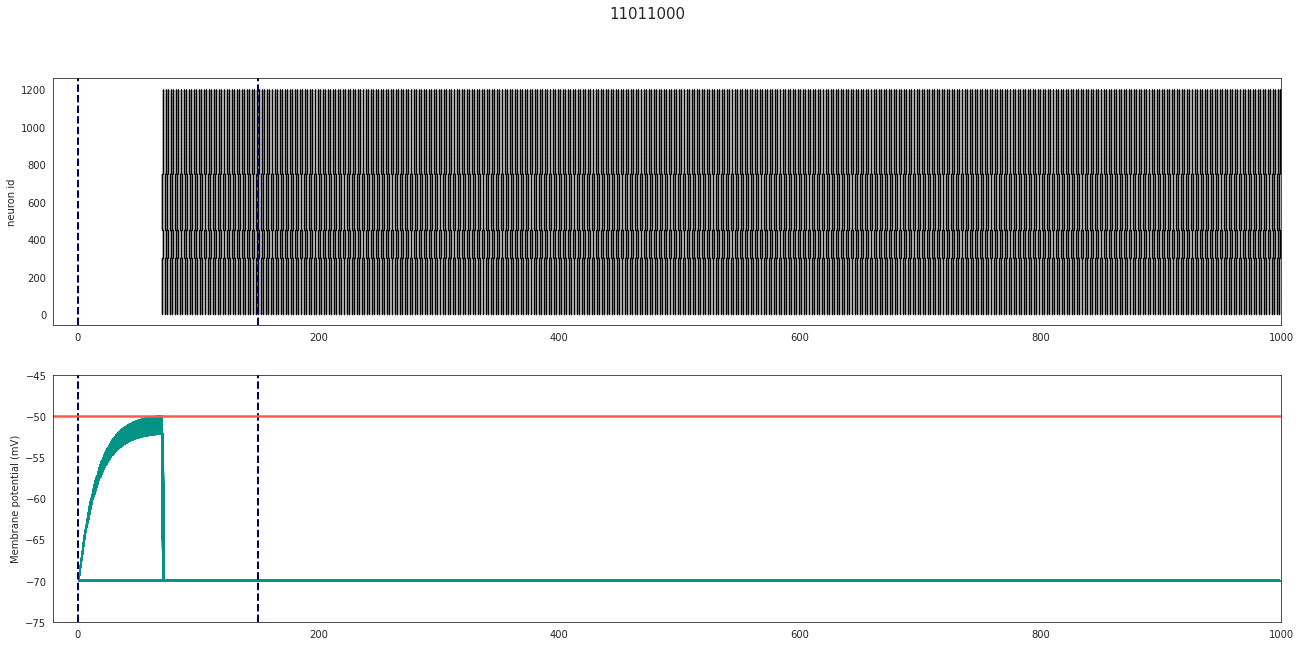

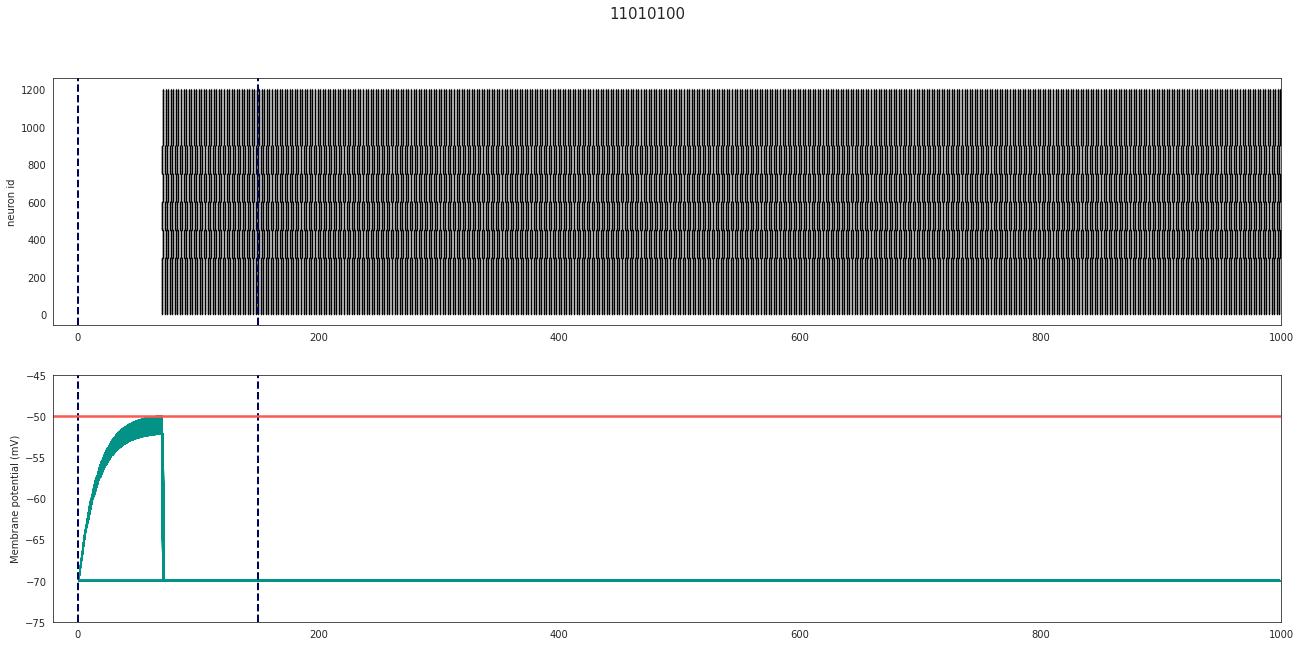

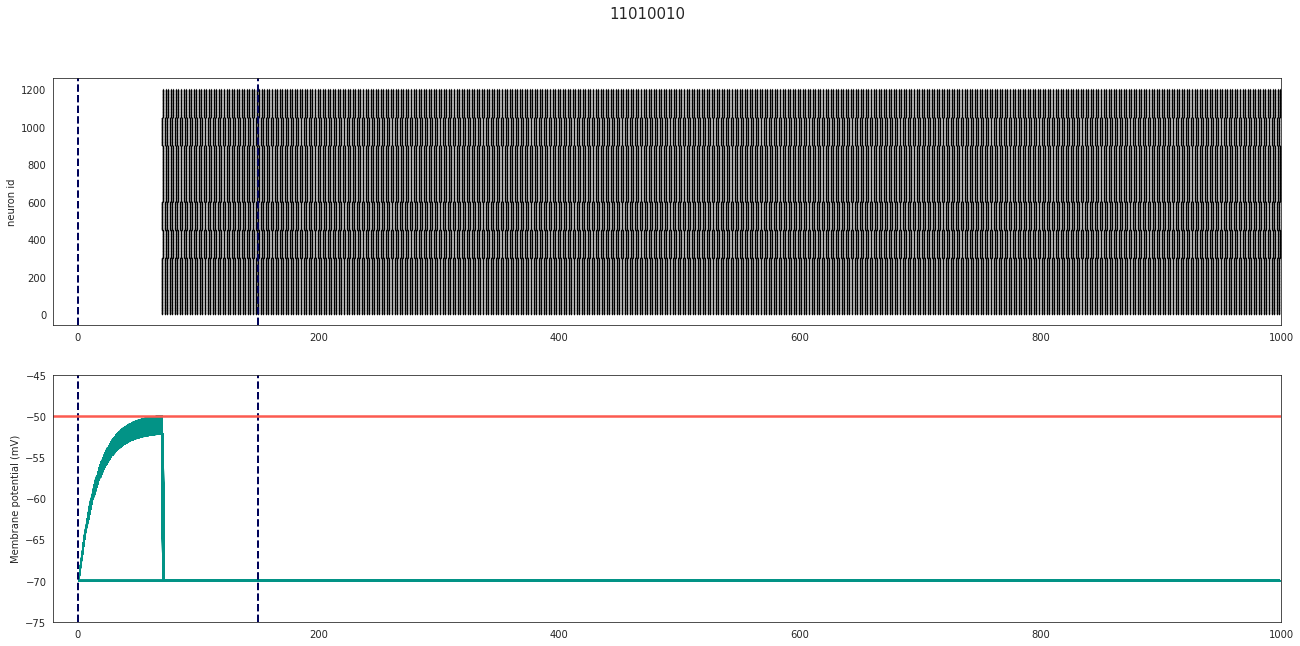

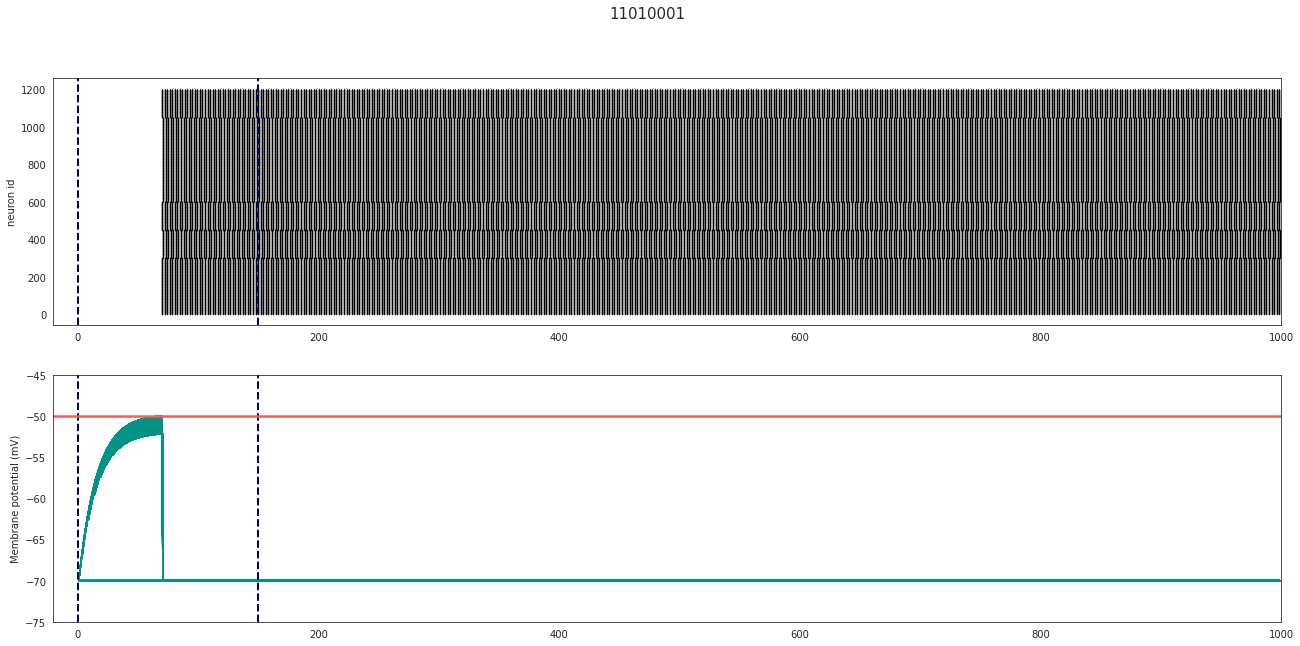

In [216]:
for i, p in enumerate(p_subset): 
    show_rasters(p, spike_times_lst[i], spike_neurons_lst[i], times_lst[i], events_lst[i], 150)